In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT

This notebook is a short demo to illustrate execution.   For odd historical reasons, it uses "toy Monte Carlo" (simulated data)for "training" and "full LHCB MC" for validation.

The network architecture is a "simple" model that uses 1 input channel (the KDE [kernel density estimator] but from the track parameters) feeding 5 convolutional layers followed by a fully connected layer.

In today's version, the network will start with weights from a previously trained version.
 

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Wed Jul 22 09:47:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 33%   51C    P2   101W / 250W |   6685MiB / 12066MiB |     83%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   79C    P0    81W / 250W |   1913MiB / 16280MiB |     91%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd
import mlflow

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

'''
HELPER FUNCTIONS
'''
# From model/collectdata.py
from model.collectdata_mdsA import collect_data

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu, Results

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below

from model.models_mjp_14July2020 import UNet_A as ModelA
from model.models_mjp_14July2020 import UNet_B as ModelB
from model.models_mjp_14July2020 import UNet_C as ModelC
from model.models_mjp_14July2020 import UNet_D as ModelD

# From model/utilities.py
from model.utilities import load_full_state, count_parameters, Params

from model.plots import dual_train_plots, replace_in_ax

## adds image of model architecture
import hiddenlayer as HL

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [4]:
device = select_gpu(1)

1 available GPUs (initially using device 0):
  0 Tesla P100-PCIE-16GB


### Set up local parameters

In [5]:
# params order - batch size, epochs, lr, epoch_start (which is usually set to 0)
args = Params(128, 1000, 1e-3, 0)

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [6]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features
train_loader = collect_data('/share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5',
                             '/share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5',
#                             '/share/lazy/sokoloff/ML-data_AA/Oct03_40K_train.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_1.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_3.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_4.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_5.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_6.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_7.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_8.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_9.h5',
                            #'/share/lazy/sokoloff/ML-data_AA/Oct03_80K2_train.h5',
                             batch_size=args.batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                            device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=False,
                            load_xy=False)

# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokoloff/ML-data_AA/
val_loader = collect_data('/share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5',
## mds val_loader = collect_data('dataAA/HLT1CPU_1kevts_val.h5',

                          batch_size=args.batch_size,
                          slice=slice(256 * 39),
                          device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=False,
                          load_xy=False)

Loading data...
Loaded /share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5 in 17.5 s
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5 in 17.23 s
Constructing 160000 event dataset took 6.28 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5 in 4.114 s
Constructing 9984 event dataset took 0.2499 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [7]:
model = ModelD()

#summary(model.to(device), (1, 4000))

mlflow.tracking.set_tracking_uri('file:/share/lazy/pv-finder_model_repo')
mlflow.set_experiment('Weird U-Net')

Traceback (most recent call last):
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/share/lazy/pv-finder_model_repo/ML/meta.yaml' does not exist.


In [8]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


Load any trained weights here:

In [9]:
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

##  use the first five layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113
##   ML -> /share/lazy/sokoloff/ML

#path = 'run_stats.pyt'
#load_full_state(model, optimizer, path)
# For other pretrained models, go to MLFlow and find the path for "run_stats.pyt" in the artifacts section
#pretrained_dict = '/share/lazy/pv-finder_model_repo/1/e67db7e2c8d949e0aeac3a6f6f426f2b/artifacts/run_stats.pyt'
#load_full_state(model, optimizer, pretrained_dict)

Let's move the model's weight matricies to the GPU:

In [10]:
model.to(device)

UNet_D(
  (d2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (d4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (rcbn1): ConvBNRelu_D(
    (0): Conv1d(1, 24, kernel_size=(25,), stride=(1,), padding=(12,))
    (1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (rcbn2): ConvBNRelu_D(
    (0): Conv1d(24, 24, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (rcbn3): ConvBNRelu_D(
    (0): Conv1d(24, 24, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (rcbn4): ConvBNRelu_D(
    (0): Conv1d(24, 24, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(24, eps=1e-05, momentum=0.1, 

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


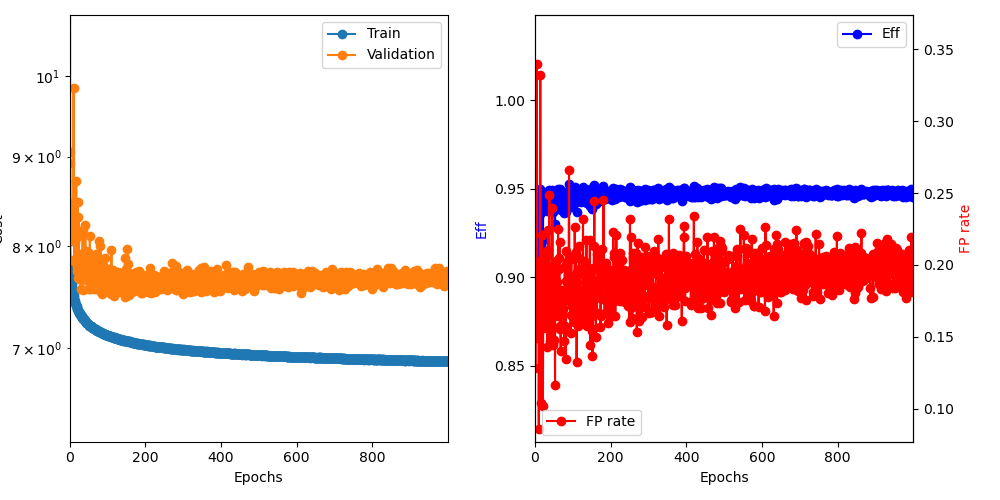

In [11]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

for model:  UNet_D(
  (d2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (d4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (rcbn1): ConvBNRelu_D(
    (0): Conv1d(1, 24, kernel_size=(25,), stride=(1,), padding=(12,))
    (1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (rcbn2): ConvBNRelu_D(
    (0): Conv1d(24, 24, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (rcbn3): ConvBNRelu_D(
    (0): Conv1d(24, 24, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (rcbn4): ConvBNRelu_D(
    (0): Conv1d(24, 24, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(24, eps=1e-05, mo

/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:95: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 0: train=62.7708, val=8.91952, took 239.86 s
  Validation Found 50299 of 54504, added 2016 (eff 92.28%) (0.202 FP/event)


Epoch 1: train=8.05116, val=9.0562, took 230.38 s
  Validation Found 49907 of 54504, added 1280 (eff 91.57%) (0.128 FP/event)


Epoch 2: train=7.84594, val=8.4178, took 223.52 s
  Validation Found 50830 of 54504, added 1929 (eff 93.26%) (0.193 FP/event)


Epoch 3: train=7.75499, val=8.31661, took 222.21 s
  Validation Found 50658 of 54504, added 1662 (eff 92.94%) (0.166 FP/event)


Epoch 4: train=7.69352, val=8.20994, took 222.86 s
  Validation Found 50611 of 54504, added 1490 (eff 92.86%) (0.149 FP/event)


Epoch 5: train=7.64513, val=8.46337, took 225.02 s
  Validation Found 51539 of 54504, added 3395 (eff 94.56%) (0.34 FP/event)


Epoch 6: train=7.61035, val=8.21894, took 234.22 s
  Validation Found 51139 of 54504, added 2027 (eff 93.83%) (0.203 FP/event)


Epoch 7: train=7.58917, val=8.10103, took 232.85 s
  Validation Found 50843 of 54504, added 1493 (eff 93.28%) (0.15 FP/event)


Epoch 8: train=7.55694, val=8.06829, took 231.36 s
  Validation Found 51161 of 54504, added 1983 (eff 93.87%) (0.199 FP/event)


Epoch 9: train=7.53157, val=8.07882, took 229.25 s
  Validation Found 51061 of 54504, added 1725 (eff 93.68%) (0.173 FP/event)


Epoch 10: train=7.50714, val=9.85146, took 235.65 s
  Validation Found 48879 of 54504, added 854 (eff 89.68%) (0.0855 FP/event)


Epoch 11: train=7.48267, val=8.1652, took 239.44 s
  Validation Found 50967 of 54504, added 1536 (eff 93.51%) (0.154 FP/event)


Epoch 12: train=7.46749, val=7.84726, took 239.11 s
  Validation Found 51328 of 54504, added 1916 (eff 94.17%) (0.192 FP/event)


Epoch 13: train=7.45129, val=8.16409, took 239.27 s
  Validation Found 50998 of 54504, added 1608 (eff 93.57%) (0.161 FP/event)


Epoch 14: train=7.43802, val=8.28476, took 239.32 s
  Validation Found 51771 of 54504, added 3319 (eff 94.99%) (0.332 FP/event)


Epoch 15: train=7.42288, val=8.0485, took 239.71 s
  Validation Found 51314 of 54504, added 1716 (eff 94.15%) (0.172 FP/event)


Epoch 16: train=7.40749, val=7.87817, took 239.09 s
  Validation Found 51311 of 54504, added 1739 (eff 94.14%) (0.174 FP/event)


Epoch 17: train=7.39511, val=8.72137, took 239.27 s
  Validation Found 50081 of 54504, added 1041 (eff 91.88%) (0.104 FP/event)


Epoch 18: train=7.3936, val=7.79062, took 239.17 s
  Validation Found 51483 of 54504, added 2205 (eff 94.46%) (0.221 FP/event)


Epoch 19: train=7.37891, val=8.09993, took 238.71 s
  Validation Found 51088 of 54504, added 1643 (eff 93.73%) (0.165 FP/event)


Epoch 20: train=7.36787, val=7.74278, took 239.11 s
  Validation Found 51167 of 54504, added 1559 (eff 93.88%) (0.156 FP/event)


Epoch 21: train=7.36006, val=8.47679, took 239.32 s
  Validation Found 50191 of 54504, added 1017 (eff 92.09%) (0.102 FP/event)


Epoch 22: train=7.35671, val=7.6701, took 239.19 s
  Validation Found 51417 of 54504, added 1871 (eff 94.34%) (0.187 FP/event)


Epoch 23: train=7.34585, val=8.31876, took 239.1 s
  Validation Found 51156 of 54504, added 1888 (eff 93.86%) (0.189 FP/event)


Epoch 24: train=7.33478, val=7.67886, took 238.89 s
  Validation Found 51606 of 54504, added 2082 (eff 94.68%) (0.209 FP/event)


Epoch 25: train=7.3305, val=7.78185, took 238.95 s
  Validation Found 51199 of 54504, added 1594 (eff 93.94%) (0.16 FP/event)


Epoch 26: train=7.32625, val=7.81294, took 239.05 s
  Validation Found 51291 of 54504, added 1807 (eff 94.11%) (0.181 FP/event)


Epoch 27: train=7.32085, val=7.77189, took 238.65 s
  Validation Found 51192 of 54504, added 1578 (eff 93.92%) (0.158 FP/event)


Epoch 28: train=7.30965, val=7.75738, took 239.24 s
  Validation Found 51206 of 54504, added 1575 (eff 93.95%) (0.158 FP/event)


Epoch 29: train=7.30724, val=7.65137, took 239.17 s
  Validation Found 51491 of 54504, added 1865 (eff 94.47%) (0.187 FP/event)


Epoch 30: train=7.30191, val=7.56039, took 238.08 s
  Validation Found 51626 of 54504, added 2051 (eff 94.72%) (0.205 FP/event)


Epoch 31: train=7.29731, val=7.81949, took 239.44 s
  Validation Found 51357 of 54504, added 1870 (eff 94.23%) (0.187 FP/event)


Epoch 32: train=7.29429, val=7.92018, took 239.6 s
  Validation Found 51387 of 54504, added 1802 (eff 94.28%) (0.18 FP/event)


Epoch 33: train=7.285, val=7.76611, took 239.65 s
  Validation Found 51108 of 54504, added 1427 (eff 93.77%) (0.143 FP/event)


Epoch 34: train=7.28127, val=8.17294, took 239.49 s
  Validation Found 51451 of 54504, added 2241 (eff 94.40%) (0.224 FP/event)


Epoch 35: train=7.27858, val=7.5567, took 239.03 s
  Validation Found 51662 of 54504, added 2103 (eff 94.79%) (0.211 FP/event)


Epoch 36: train=7.27422, val=7.92963, took 239.38 s
  Validation Found 51173 of 54504, added 1562 (eff 93.89%) (0.156 FP/event)


Epoch 37: train=7.2671, val=7.82116, took 239.22 s
  Validation Found 51291 of 54504, added 1580 (eff 94.11%) (0.158 FP/event)


Epoch 38: train=7.26819, val=7.79474, took 239.4 s
  Validation Found 51754 of 54504, added 2486 (eff 94.95%) (0.249 FP/event)


Epoch 39: train=7.25901, val=7.84472, took 239.08 s
  Validation Found 51175 of 54504, added 1468 (eff 93.89%) (0.147 FP/event)


Epoch 40: train=7.25628, val=7.82173, took 235.35 s
  Validation Found 51388 of 54504, added 1720 (eff 94.28%) (0.172 FP/event)


Epoch 41: train=7.25366, val=8.22557, took 239.3 s
  Validation Found 51144 of 54504, added 1858 (eff 93.84%) (0.186 FP/event)


Epoch 42: train=7.24834, val=7.91623, took 239.45 s
  Validation Found 51315 of 54504, added 1751 (eff 94.15%) (0.175 FP/event)


Epoch 43: train=7.23937, val=7.71011, took 239.32 s
  Validation Found 51574 of 54504, added 1985 (eff 94.62%) (0.199 FP/event)


Epoch 44: train=7.24141, val=7.94841, took 239.41 s
  Validation Found 51236 of 54504, added 1485 (eff 94.00%) (0.149 FP/event)


Epoch 45: train=7.23681, val=7.85257, took 239.17 s
  Validation Found 51238 of 54504, added 1559 (eff 94.01%) (0.156 FP/event)


Epoch 46: train=7.23475, val=7.69437, took 239.27 s
  Validation Found 51733 of 54504, added 2396 (eff 94.92%) (0.24 FP/event)


Epoch 47: train=7.22595, val=7.94517, took 239.24 s
  Validation Found 51070 of 54504, added 1439 (eff 93.70%) (0.144 FP/event)


Epoch 48: train=7.22177, val=7.81397, took 239.57 s
  Validation Found 51172 of 54504, added 1458 (eff 93.89%) (0.146 FP/event)


Epoch 49: train=7.22465, val=7.64496, took 239.21 s
  Validation Found 51622 of 54504, added 2003 (eff 94.71%) (0.201 FP/event)


Epoch 50: train=7.21974, val=7.83521, took 238.09 s
  Validation Found 51158 of 54504, added 1474 (eff 93.86%) (0.148 FP/event)


Epoch 51: train=7.21674, val=7.68599, took 239.49 s
  Validation Found 51420 of 54504, added 1742 (eff 94.34%) (0.174 FP/event)


Epoch 52: train=7.2103, val=7.56805, took 239.41 s
  Validation Found 51627 of 54504, added 1963 (eff 94.72%) (0.197 FP/event)


Epoch 53: train=7.20892, val=8.11052, took 239.29 s
  Validation Found 50702 of 54504, added 1161 (eff 93.02%) (0.116 FP/event)


Epoch 54: train=7.20591, val=7.56516, took 239.07 s
  Validation Found 51577 of 54504, added 1957 (eff 94.63%) (0.196 FP/event)


Epoch 55: train=7.2044, val=7.80033, took 239.15 s
  Validation Found 51581 of 54504, added 2024 (eff 94.64%) (0.203 FP/event)


Epoch 56: train=7.20448, val=7.62419, took 239.15 s
  Validation Found 51578 of 54504, added 1889 (eff 94.63%) (0.189 FP/event)


Epoch 57: train=7.20328, val=7.72004, took 239.41 s
  Validation Found 51567 of 54504, added 1877 (eff 94.61%) (0.188 FP/event)


Epoch 58: train=7.19739, val=7.64973, took 239.24 s
  Validation Found 51494 of 54504, added 1753 (eff 94.48%) (0.176 FP/event)


Epoch 59: train=7.19276, val=7.73902, took 238.9 s
  Validation Found 51391 of 54504, added 1687 (eff 94.29%) (0.169 FP/event)


Epoch 60: train=7.19016, val=7.64576, took 237.89 s
  Validation Found 51505 of 54504, added 1764 (eff 94.50%) (0.177 FP/event)


Epoch 61: train=7.18958, val=7.62379, took 239.07 s
  Validation Found 51762 of 54504, added 2247 (eff 94.97%) (0.225 FP/event)


Epoch 62: train=7.18484, val=7.65857, took 238.88 s
  Validation Found 51433 of 54504, added 1643 (eff 94.37%) (0.165 FP/event)


Epoch 63: train=7.18477, val=7.63964, took 239.27 s
  Validation Found 51607 of 54504, added 1969 (eff 94.68%) (0.197 FP/event)


Epoch 64: train=7.17917, val=7.56292, took 239.53 s
  Validation Found 51669 of 54504, added 2048 (eff 94.80%) (0.205 FP/event)


Epoch 65: train=7.18228, val=7.57715, took 239.2 s
  Validation Found 51768 of 54504, added 2159 (eff 94.98%) (0.216 FP/event)


Epoch 66: train=7.17491, val=7.81603, took 239.19 s
  Validation Found 51234 of 54504, added 1554 (eff 94.00%) (0.156 FP/event)


Epoch 67: train=7.17381, val=7.88974, took 239.48 s
  Validation Found 51264 of 54504, added 1574 (eff 94.06%) (0.158 FP/event)


Epoch 68: train=7.17355, val=7.92362, took 239.01 s
  Validation Found 51132 of 54504, added 1401 (eff 93.81%) (0.14 FP/event)


Epoch 69: train=7.16697, val=7.8073, took 239.71 s
  Validation Found 51387 of 54504, added 1675 (eff 94.28%) (0.168 FP/event)


Epoch 70: train=7.16608, val=7.74921, took 238.39 s
  Validation Found 51450 of 54504, added 1681 (eff 94.40%) (0.168 FP/event)


Epoch 71: train=7.16352, val=7.65773, took 239.64 s
  Validation Found 51496 of 54504, added 1677 (eff 94.48%) (0.168 FP/event)


Epoch 72: train=7.16769, val=7.6107, took 239.37 s
  Validation Found 51534 of 54504, added 1825 (eff 94.55%) (0.183 FP/event)


Epoch 73: train=7.16308, val=7.70482, took 238.42 s
  Validation Found 51410 of 54504, added 1691 (eff 94.32%) (0.169 FP/event)


Epoch 74: train=7.15797, val=7.70692, took 238.46 s
  Validation Found 51409 of 54504, added 1698 (eff 94.32%) (0.17 FP/event)


Epoch 75: train=7.15567, val=7.63865, took 238.84 s
  Validation Found 51409 of 54504, added 1579 (eff 94.32%) (0.158 FP/event)


Epoch 76: train=7.15736, val=7.86878, took 239.0 s
  Validation Found 51269 of 54504, added 1555 (eff 94.06%) (0.156 FP/event)


Epoch 77: train=7.15844, val=8.05723, took 239.34 s
  Validation Found 51038 of 54504, added 1469 (eff 93.64%) (0.147 FP/event)


Epoch 78: train=7.15361, val=7.7176, took 239.39 s
  Validation Found 51501 of 54504, added 1748 (eff 94.49%) (0.175 FP/event)


Epoch 79: train=7.14832, val=7.54686, took 239.19 s
  Validation Found 51681 of 54504, added 1990 (eff 94.82%) (0.199 FP/event)


Epoch 80: train=7.14937, val=7.80732, took 238.57 s
  Validation Found 51300 of 54504, added 1572 (eff 94.12%) (0.157 FP/event)


Epoch 81: train=7.14859, val=8.00045, took 239.28 s
  Validation Found 51056 of 54504, added 1347 (eff 93.67%) (0.135 FP/event)


Epoch 82: train=7.14733, val=7.59397, took 239.46 s
  Validation Found 51594 of 54504, added 2092 (eff 94.66%) (0.21 FP/event)


Epoch 83: train=7.14507, val=7.60856, took 239.01 s
  Validation Found 51648 of 54504, added 1888 (eff 94.76%) (0.189 FP/event)


Epoch 84: train=7.14198, val=7.7114, took 238.95 s
  Validation Found 51575 of 54504, added 1792 (eff 94.63%) (0.179 FP/event)


Epoch 85: train=7.14007, val=7.51093, took 239.13 s
  Validation Found 51693 of 54504, added 2019 (eff 94.84%) (0.202 FP/event)


Epoch 86: train=7.13775, val=7.63621, took 239.11 s
  Validation Found 51601 of 54504, added 1929 (eff 94.67%) (0.193 FP/event)


Epoch 87: train=7.14044, val=7.57936, took 239.42 s
  Validation Found 51585 of 54504, added 1833 (eff 94.64%) (0.184 FP/event)


Epoch 88: train=7.13563, val=7.80827, took 239.36 s
  Validation Found 51417 of 54504, added 1811 (eff 94.34%) (0.181 FP/event)


Epoch 89: train=7.13734, val=7.65967, took 239.2 s
  Validation Found 51693 of 54504, added 2056 (eff 94.84%) (0.206 FP/event)


Epoch 90: train=7.13341, val=7.60635, took 238.54 s
  Validation Found 51936 of 54504, added 2657 (eff 95.29%) (0.266 FP/event)


Epoch 91: train=7.1299, val=7.57452, took 240.27 s
  Validation Found 51601 of 54504, added 1861 (eff 94.67%) (0.186 FP/event)


Epoch 92: train=7.1293, val=7.55727, took 240.32 s
  Validation Found 51675 of 54504, added 1899 (eff 94.81%) (0.19 FP/event)


Epoch 93: train=7.12698, val=7.7247, took 240.26 s
  Validation Found 51474 of 54504, added 1759 (eff 94.44%) (0.176 FP/event)


Epoch 94: train=7.12369, val=7.87528, took 240.19 s
  Validation Found 51226 of 54504, added 1522 (eff 93.99%) (0.152 FP/event)


Epoch 95: train=7.12437, val=7.70217, took 240.0 s
  Validation Found 51445 of 54504, added 1652 (eff 94.39%) (0.165 FP/event)


Epoch 96: train=7.12276, val=7.55718, took 239.96 s
  Validation Found 51766 of 54504, added 2037 (eff 94.98%) (0.204 FP/event)


Epoch 97: train=7.12079, val=7.69159, took 240.19 s
  Validation Found 51542 of 54504, added 1716 (eff 94.57%) (0.172 FP/event)


Epoch 98: train=7.11944, val=7.72175, took 240.19 s
  Validation Found 51539 of 54504, added 1712 (eff 94.56%) (0.171 FP/event)


Epoch 99: train=7.1193, val=7.68053, took 240.27 s
  Validation Found 51447 of 54504, added 1739 (eff 94.39%) (0.174 FP/event)


Epoch 100: train=7.11667, val=7.73065, took 238.92 s
  Validation Found 51542 of 54504, added 1921 (eff 94.57%) (0.192 FP/event)


Epoch 101: train=7.11741, val=7.61626, took 239.5 s
  Validation Found 51498 of 54504, added 1697 (eff 94.48%) (0.17 FP/event)


Epoch 102: train=7.11707, val=7.62952, took 239.54 s
  Validation Found 51585 of 54504, added 1818 (eff 94.64%) (0.182 FP/event)


Epoch 103: train=7.11458, val=7.68547, took 239.5 s
  Validation Found 51588 of 54504, added 1773 (eff 94.65%) (0.178 FP/event)


Epoch 104: train=7.11229, val=7.76736, took 239.44 s
  Validation Found 51296 of 54504, added 1601 (eff 94.11%) (0.16 FP/event)


Epoch 105: train=7.10925, val=7.54924, took 239.71 s
  Validation Found 51829 of 54504, added 2263 (eff 95.09%) (0.227 FP/event)


Epoch 106: train=7.10818, val=7.68422, took 239.39 s
  Validation Found 51579 of 54504, added 1778 (eff 94.63%) (0.178 FP/event)


Epoch 107: train=7.10931, val=7.66407, took 239.33 s
  Validation Found 51620 of 54504, added 1836 (eff 94.71%) (0.184 FP/event)


Epoch 108: train=7.10625, val=7.51215, took 239.42 s
  Validation Found 51748 of 54504, added 2090 (eff 94.94%) (0.209 FP/event)


Epoch 109: train=7.1082, val=7.67858, took 239.09 s
  Validation Found 51579 of 54504, added 1817 (eff 94.63%) (0.182 FP/event)


Epoch 110: train=7.10263, val=7.95669, took 238.28 s
  Validation Found 51075 of 54504, added 1322 (eff 93.71%) (0.132 FP/event)


Epoch 111: train=7.10189, val=7.72876, took 239.51 s
  Validation Found 51474 of 54504, added 1666 (eff 94.44%) (0.167 FP/event)


Epoch 112: train=7.10321, val=7.66137, took 239.37 s
  Validation Found 51679 of 54504, added 1949 (eff 94.82%) (0.195 FP/event)


Epoch 113: train=7.09958, val=7.66911, took 239.35 s
  Validation Found 51565 of 54504, added 1779 (eff 94.61%) (0.178 FP/event)


Epoch 114: train=7.10068, val=7.75375, took 239.17 s
  Validation Found 51417 of 54504, added 1575 (eff 94.34%) (0.158 FP/event)


Epoch 115: train=7.10035, val=7.62221, took 239.27 s
  Validation Found 51654 of 54504, added 1930 (eff 94.77%) (0.193 FP/event)


Epoch 116: train=7.09653, val=7.61423, took 239.22 s
  Validation Found 51742 of 54504, added 2132 (eff 94.93%) (0.214 FP/event)


Epoch 117: train=7.09778, val=7.49879, took 239.26 s
  Validation Found 51707 of 54504, added 2045 (eff 94.87%) (0.205 FP/event)


Epoch 118: train=7.09602, val=7.53857, took 239.34 s
  Validation Found 51550 of 54504, added 1752 (eff 94.58%) (0.175 FP/event)


Epoch 119: train=7.09605, val=7.6146, took 239.29 s
  Validation Found 51671 of 54504, added 1969 (eff 94.80%) (0.197 FP/event)


Epoch 120: train=7.09938, val=7.65894, took 238.21 s
  Validation Found 51456 of 54504, added 1645 (eff 94.41%) (0.165 FP/event)


Epoch 121: train=7.08999, val=7.61431, took 239.59 s
  Validation Found 51507 of 54504, added 1702 (eff 94.50%) (0.17 FP/event)


Epoch 122: train=7.08931, val=7.72433, took 239.64 s
  Validation Found 51384 of 54504, added 1584 (eff 94.28%) (0.159 FP/event)


Epoch 123: train=7.0924, val=7.71482, took 239.25 s
  Validation Found 51434 of 54504, added 1682 (eff 94.37%) (0.168 FP/event)


Epoch 124: train=7.08791, val=7.65087, took 239.26 s
  Validation Found 51582 of 54504, added 1808 (eff 94.64%) (0.181 FP/event)


Epoch 125: train=7.08971, val=7.60414, took 239.07 s
  Validation Found 51548 of 54504, added 1783 (eff 94.58%) (0.179 FP/event)


Epoch 126: train=7.08911, val=7.6633, took 239.34 s
  Validation Found 51542 of 54504, added 1771 (eff 94.57%) (0.177 FP/event)


Epoch 127: train=7.08707, val=7.53966, took 239.53 s
  Validation Found 51847 of 54504, added 2317 (eff 95.13%) (0.232 FP/event)


Epoch 128: train=7.0848, val=7.73346, took 239.29 s
  Validation Found 51498 of 54504, added 1683 (eff 94.48%) (0.169 FP/event)


Epoch 129: train=7.0835, val=7.60243, took 239.34 s
  Validation Found 51712 of 54504, added 2026 (eff 94.88%) (0.203 FP/event)


Epoch 130: train=7.0816, val=7.64037, took 238.09 s
  Validation Found 51572 of 54504, added 1828 (eff 94.62%) (0.183 FP/event)


Epoch 131: train=7.08103, val=7.69182, took 239.32 s
  Validation Found 51384 of 54504, added 1607 (eff 94.28%) (0.161 FP/event)


Epoch 132: train=7.0815, val=7.69159, took 239.7 s
  Validation Found 51431 of 54504, added 1618 (eff 94.36%) (0.162 FP/event)


Epoch 133: train=7.07857, val=7.65255, took 239.19 s
  Validation Found 51553 of 54504, added 1878 (eff 94.59%) (0.188 FP/event)


Epoch 134: train=7.07859, val=7.55138, took 239.76 s
  Validation Found 51721 of 54504, added 1968 (eff 94.89%) (0.197 FP/event)


Epoch 135: train=7.07597, val=7.63981, took 239.29 s
  Validation Found 51565 of 54504, added 1759 (eff 94.61%) (0.176 FP/event)


Epoch 136: train=7.08139, val=7.57697, took 239.23 s
  Validation Found 51738 of 54504, added 2173 (eff 94.93%) (0.218 FP/event)


Epoch 137: train=7.07823, val=7.72756, took 239.33 s
  Validation Found 51337 of 54504, added 1572 (eff 94.19%) (0.157 FP/event)


Epoch 138: train=7.07562, val=7.57782, took 239.38 s
  Validation Found 51635 of 54504, added 1978 (eff 94.74%) (0.198 FP/event)


Epoch 139: train=7.07437, val=7.62795, took 239.33 s
  Validation Found 51678 of 54504, added 1964 (eff 94.82%) (0.197 FP/event)


Epoch 140: train=7.07444, val=7.58056, took 237.94 s
  Validation Found 51659 of 54504, added 1931 (eff 94.78%) (0.193 FP/event)


Epoch 141: train=7.07053, val=7.64224, took 239.24 s
  Validation Found 51617 of 54504, added 1851 (eff 94.70%) (0.185 FP/event)


Epoch 142: train=7.07327, val=7.69206, took 239.28 s
  Validation Found 51617 of 54504, added 1875 (eff 94.70%) (0.188 FP/event)


Epoch 143: train=7.07065, val=7.52998, took 239.23 s
  Validation Found 51700 of 54504, added 1977 (eff 94.86%) (0.198 FP/event)


Epoch 144: train=7.07164, val=7.63772, took 239.24 s
  Validation Found 51428 of 54504, added 1601 (eff 94.36%) (0.16 FP/event)


Epoch 145: train=7.06993, val=7.48221, took 239.22 s
  Validation Found 51778 of 54504, added 2173 (eff 95.00%) (0.218 FP/event)


Epoch 146: train=7.06682, val=7.88091, took 239.33 s
  Validation Found 51256 of 54504, added 1441 (eff 94.04%) (0.144 FP/event)


Epoch 147: train=7.06743, val=7.68984, took 239.47 s
  Validation Found 51664 of 54504, added 1947 (eff 94.79%) (0.195 FP/event)


Epoch 148: train=7.06957, val=7.76827, took 239.39 s
  Validation Found 51455 of 54504, added 1679 (eff 94.41%) (0.168 FP/event)


Epoch 149: train=7.06742, val=7.51939, took 239.17 s
  Validation Found 51667 of 54504, added 1884 (eff 94.79%) (0.189 FP/event)


Epoch 150: train=7.06584, val=7.74905, took 238.55 s
  Validation Found 51380 of 54504, added 1536 (eff 94.27%) (0.154 FP/event)


Epoch 151: train=7.06424, val=7.57216, took 239.62 s
  Validation Found 51478 of 54504, added 1643 (eff 94.45%) (0.165 FP/event)


Epoch 152: train=7.06375, val=7.97249, took 239.28 s
  Validation Found 51147 of 54504, added 1363 (eff 93.84%) (0.137 FP/event)


Epoch 153: train=7.0629, val=7.81669, took 239.44 s
  Validation Found 51295 of 54504, added 1549 (eff 94.11%) (0.155 FP/event)


Epoch 154: train=7.06415, val=7.58084, took 239.37 s
  Validation Found 51683 of 54504, added 1891 (eff 94.82%) (0.189 FP/event)


Epoch 155: train=7.06152, val=7.527, took 239.45 s
  Validation Found 51700 of 54504, added 1976 (eff 94.86%) (0.198 FP/event)


Epoch 156: train=7.0589, val=7.50373, took 239.29 s
  Validation Found 51802 of 54504, added 2128 (eff 95.04%) (0.213 FP/event)


Epoch 157: train=7.06136, val=7.52856, took 238.88 s
  Validation Found 51906 of 54504, added 2442 (eff 95.23%) (0.245 FP/event)


Epoch 158: train=7.05742, val=7.66408, took 239.27 s
  Validation Found 51467 of 54504, added 1653 (eff 94.43%) (0.166 FP/event)


Epoch 159: train=7.06259, val=7.68752, took 239.42 s
  Validation Found 51488 of 54504, added 1669 (eff 94.47%) (0.167 FP/event)


Epoch 160: train=7.05978, val=7.54539, took 238.54 s
  Validation Found 51628 of 54504, added 1833 (eff 94.72%) (0.184 FP/event)


Epoch 161: train=7.05538, val=7.71396, took 239.65 s
  Validation Found 51301 of 54504, added 1495 (eff 94.12%) (0.15 FP/event)


Epoch 162: train=7.0568, val=7.5772, took 239.26 s
  Validation Found 51609 of 54504, added 1811 (eff 94.69%) (0.181 FP/event)


Epoch 163: train=7.05419, val=7.5682, took 239.39 s
  Validation Found 51631 of 54504, added 1862 (eff 94.73%) (0.186 FP/event)


Epoch 164: train=7.05198, val=7.71153, took 239.16 s
  Validation Found 51486 of 54504, added 1658 (eff 94.46%) (0.166 FP/event)


Epoch 165: train=7.05295, val=7.53954, took 239.28 s
  Validation Found 51778 of 54504, added 2070 (eff 95.00%) (0.207 FP/event)


Epoch 166: train=7.05571, val=7.55831, took 239.27 s
  Validation Found 51687 of 54504, added 2018 (eff 94.83%) (0.202 FP/event)


Epoch 167: train=7.05157, val=7.56727, took 238.99 s
  Validation Found 51598 of 54504, added 1796 (eff 94.67%) (0.18 FP/event)


Epoch 168: train=7.05129, val=7.60911, took 239.05 s
  Validation Found 51570 of 54504, added 1779 (eff 94.62%) (0.178 FP/event)


Epoch 169: train=7.04883, val=7.56368, took 238.99 s
  Validation Found 51666 of 54504, added 1978 (eff 94.79%) (0.198 FP/event)


Epoch 170: train=7.05192, val=7.54348, took 238.19 s
  Validation Found 51718 of 54504, added 2010 (eff 94.89%) (0.201 FP/event)


Epoch 171: train=7.04916, val=7.57446, took 239.39 s
  Validation Found 51582 of 54504, added 1767 (eff 94.64%) (0.177 FP/event)


Epoch 172: train=7.04605, val=7.57524, took 239.68 s
  Validation Found 51726 of 54504, added 2025 (eff 94.90%) (0.203 FP/event)


Epoch 173: train=7.04869, val=7.68634, took 239.54 s
  Validation Found 51399 of 54504, added 1569 (eff 94.30%) (0.157 FP/event)


Epoch 174: train=7.04614, val=7.73254, took 239.3 s
  Validation Found 51432 of 54504, added 1644 (eff 94.36%) (0.165 FP/event)


Epoch 175: train=7.04953, val=7.69888, took 238.99 s
  Validation Found 51609 of 54504, added 1955 (eff 94.69%) (0.196 FP/event)


Epoch 176: train=7.04538, val=7.64357, took 238.89 s
  Validation Found 51753 of 54504, added 2106 (eff 94.95%) (0.211 FP/event)


Epoch 177: train=7.0422, val=7.65276, took 239.22 s
  Validation Found 51553 of 54504, added 1768 (eff 94.59%) (0.177 FP/event)


Epoch 178: train=7.04227, val=7.57892, took 239.02 s
  Validation Found 51680 of 54504, added 1895 (eff 94.82%) (0.19 FP/event)


Epoch 179: train=7.04424, val=7.58633, took 239.25 s
  Validation Found 51666 of 54504, added 1921 (eff 94.79%) (0.192 FP/event)


Epoch 180: train=7.04497, val=7.59465, took 238.05 s
  Validation Found 51684 of 54504, added 1898 (eff 94.83%) (0.19 FP/event)


Epoch 181: train=7.04264, val=7.61541, took 239.03 s
  Validation Found 51859 of 54504, added 2446 (eff 95.15%) (0.245 FP/event)


Epoch 182: train=7.04148, val=7.64438, took 239.41 s
  Validation Found 51684 of 54504, added 1967 (eff 94.83%) (0.197 FP/event)


Epoch 183: train=7.04189, val=7.62148, took 239.43 s
  Validation Found 51629 of 54504, added 1845 (eff 94.73%) (0.185 FP/event)


Epoch 184: train=7.0418, val=7.74861, took 239.33 s
  Validation Found 51475 of 54504, added 1662 (eff 94.44%) (0.166 FP/event)


Epoch 185: train=7.04212, val=7.62526, took 239.21 s
  Validation Found 51573 of 54504, added 1757 (eff 94.62%) (0.176 FP/event)


Epoch 186: train=7.03895, val=7.64852, took 239.27 s
  Validation Found 51630 of 54504, added 1902 (eff 94.73%) (0.19 FP/event)


Epoch 187: train=7.03922, val=7.52172, took 238.56 s
  Validation Found 51698 of 54504, added 2008 (eff 94.85%) (0.201 FP/event)


Epoch 188: train=7.04015, val=7.69989, took 239.11 s
  Validation Found 51687 of 54504, added 1930 (eff 94.83%) (0.193 FP/event)


Epoch 189: train=7.03712, val=7.65992, took 239.21 s
  Validation Found 51596 of 54504, added 1847 (eff 94.66%) (0.185 FP/event)


Epoch 190: train=7.03684, val=7.52831, took 238.11 s
  Validation Found 51582 of 54504, added 1786 (eff 94.64%) (0.179 FP/event)


Epoch 191: train=7.03901, val=7.53195, took 239.03 s
  Validation Found 51702 of 54504, added 1941 (eff 94.86%) (0.194 FP/event)


Epoch 192: train=7.03583, val=7.64743, took 239.36 s
  Validation Found 51494 of 54504, added 1597 (eff 94.48%) (0.16 FP/event)


Epoch 193: train=7.03168, val=7.60118, took 239.39 s
  Validation Found 51653 of 54504, added 1917 (eff 94.77%) (0.192 FP/event)


Epoch 194: train=7.03472, val=7.70818, took 239.13 s
  Validation Found 51520 of 54504, added 1717 (eff 94.53%) (0.172 FP/event)


Epoch 195: train=7.03346, val=7.602, took 239.01 s
  Validation Found 51606 of 54504, added 1791 (eff 94.68%) (0.179 FP/event)


Epoch 196: train=7.03462, val=7.59762, took 239.11 s
  Validation Found 51665 of 54504, added 1896 (eff 94.79%) (0.19 FP/event)


Epoch 197: train=7.03241, val=7.60597, took 239.11 s
  Validation Found 51603 of 54504, added 1865 (eff 94.68%) (0.187 FP/event)


Epoch 198: train=7.03102, val=7.64543, took 239.43 s
  Validation Found 51522 of 54504, added 1687 (eff 94.53%) (0.169 FP/event)


Epoch 199: train=7.03163, val=7.60192, took 238.6 s
  Validation Found 51702 of 54504, added 1959 (eff 94.86%) (0.196 FP/event)


Epoch 200: train=7.03058, val=7.69919, took 237.47 s
  Validation Found 51464 of 54504, added 1689 (eff 94.42%) (0.169 FP/event)


Epoch 201: train=7.02995, val=7.6754, took 239.34 s
  Validation Found 51506 of 54504, added 1705 (eff 94.50%) (0.171 FP/event)


Epoch 202: train=7.02924, val=7.60933, took 239.23 s
  Validation Found 51633 of 54504, added 1879 (eff 94.73%) (0.188 FP/event)


Epoch 203: train=7.02956, val=7.70564, took 239.28 s
  Validation Found 51423 of 54504, added 1639 (eff 94.35%) (0.164 FP/event)


Epoch 204: train=7.02935, val=7.62357, took 239.13 s
  Validation Found 51507 of 54504, added 1657 (eff 94.50%) (0.166 FP/event)


Epoch 205: train=7.0263, val=7.67843, took 239.72 s
  Validation Found 51578 of 54504, added 1833 (eff 94.63%) (0.184 FP/event)


Epoch 206: train=7.02726, val=7.6527, took 239.24 s
  Validation Found 51543 of 54504, added 1737 (eff 94.57%) (0.174 FP/event)


Epoch 207: train=7.02406, val=7.53193, took 239.31 s
  Validation Found 51806 of 54504, added 2224 (eff 95.05%) (0.223 FP/event)


Epoch 208: train=7.02789, val=7.61161, took 239.29 s
  Validation Found 51724 of 54504, added 2078 (eff 94.90%) (0.208 FP/event)


Epoch 209: train=7.0225, val=7.58687, took 239.37 s
  Validation Found 51723 of 54504, added 2051 (eff 94.90%) (0.205 FP/event)


Epoch 210: train=7.02473, val=7.61412, took 238.19 s
  Validation Found 51623 of 54504, added 1854 (eff 94.71%) (0.186 FP/event)


Epoch 211: train=7.02381, val=7.61965, took 239.15 s
  Validation Found 51644 of 54504, added 1939 (eff 94.75%) (0.194 FP/event)


Epoch 212: train=7.02329, val=7.77883, took 239.12 s
  Validation Found 51476 of 54504, added 1639 (eff 94.44%) (0.164 FP/event)


Epoch 213: train=7.02488, val=7.66353, took 238.86 s
  Validation Found 51589 of 54504, added 1782 (eff 94.65%) (0.178 FP/event)


Epoch 214: train=7.02001, val=7.52805, took 239.38 s
  Validation Found 51606 of 54504, added 1822 (eff 94.68%) (0.182 FP/event)


Epoch 215: train=7.02218, val=7.59288, took 239.37 s
  Validation Found 51772 of 54504, added 2207 (eff 94.99%) (0.221 FP/event)


Epoch 216: train=7.02107, val=7.59761, took 239.3 s
  Validation Found 51680 of 54504, added 1992 (eff 94.82%) (0.199 FP/event)


Epoch 217: train=7.01929, val=7.57879, took 239.39 s
  Validation Found 51676 of 54504, added 1925 (eff 94.81%) (0.193 FP/event)


Epoch 218: train=7.01963, val=7.67018, took 239.11 s
  Validation Found 51648 of 54504, added 1806 (eff 94.76%) (0.181 FP/event)


Epoch 219: train=7.01687, val=7.63119, took 239.2 s
  Validation Found 51600 of 54504, added 1777 (eff 94.67%) (0.178 FP/event)


Epoch 220: train=7.01868, val=7.6166, took 238.3 s
  Validation Found 51550 of 54504, added 1796 (eff 94.58%) (0.18 FP/event)


Epoch 221: train=7.02293, val=7.69278, took 239.43 s
  Validation Found 51540 of 54504, added 1789 (eff 94.56%) (0.179 FP/event)


Epoch 222: train=7.01823, val=7.70188, took 239.28 s
  Validation Found 51563 of 54504, added 1769 (eff 94.60%) (0.177 FP/event)


Epoch 223: train=7.01851, val=7.59541, took 239.22 s
  Validation Found 51666 of 54504, added 1958 (eff 94.79%) (0.196 FP/event)


Epoch 224: train=7.01517, val=7.53886, took 239.59 s
  Validation Found 51770 of 54504, added 2081 (eff 94.98%) (0.208 FP/event)


Epoch 225: train=7.01603, val=7.68794, took 239.46 s
  Validation Found 51544 of 54504, added 1744 (eff 94.57%) (0.175 FP/event)


Epoch 226: train=7.01498, val=7.62051, took 239.33 s
  Validation Found 51637 of 54504, added 1891 (eff 94.74%) (0.189 FP/event)


Epoch 227: train=7.01477, val=7.59894, took 239.21 s
  Validation Found 51661 of 54504, added 1967 (eff 94.78%) (0.197 FP/event)


Epoch 228: train=7.01458, val=7.60606, took 239.37 s
  Validation Found 51593 of 54504, added 1803 (eff 94.66%) (0.181 FP/event)


Epoch 229: train=7.0142, val=7.69528, took 239.29 s
  Validation Found 51738 of 54504, added 2030 (eff 94.93%) (0.203 FP/event)


Epoch 230: train=7.01258, val=7.61658, took 237.71 s
  Validation Found 51623 of 54504, added 1809 (eff 94.71%) (0.181 FP/event)


Epoch 231: train=7.01353, val=7.66428, took 238.63 s
  Validation Found 51637 of 54504, added 1917 (eff 94.74%) (0.192 FP/event)


Epoch 232: train=7.01191, val=7.60623, took 238.81 s
  Validation Found 51607 of 54504, added 1858 (eff 94.68%) (0.186 FP/event)


Epoch 233: train=7.0147, val=7.57603, took 238.98 s
  Validation Found 51599 of 54504, added 1813 (eff 94.67%) (0.182 FP/event)


Epoch 234: train=7.01226, val=7.57246, took 239.39 s
  Validation Found 51580 of 54504, added 1856 (eff 94.64%) (0.186 FP/event)


Epoch 235: train=7.00751, val=7.60647, took 239.14 s
  Validation Found 51689 of 54504, added 1920 (eff 94.84%) (0.192 FP/event)


Epoch 236: train=7.01045, val=7.62587, took 239.1 s
  Validation Found 51658 of 54504, added 1961 (eff 94.78%) (0.196 FP/event)


Epoch 237: train=7.01137, val=7.63877, took 238.58 s
  Validation Found 51523 of 54504, added 1767 (eff 94.53%) (0.177 FP/event)


Epoch 238: train=7.01256, val=7.63924, took 238.66 s
  Validation Found 51542 of 54504, added 1742 (eff 94.57%) (0.174 FP/event)


Epoch 239: train=7.01034, val=7.67677, took 239.37 s
  Validation Found 51541 of 54504, added 1739 (eff 94.56%) (0.174 FP/event)


Epoch 240: train=7.01263, val=7.60761, took 238.33 s
  Validation Found 51634 of 54504, added 1849 (eff 94.73%) (0.185 FP/event)


Epoch 241: train=7.00996, val=7.56773, took 239.41 s
  Validation Found 51679 of 54504, added 1897 (eff 94.82%) (0.19 FP/event)


Epoch 242: train=7.00773, val=7.58853, took 239.01 s
  Validation Found 51623 of 54504, added 1901 (eff 94.71%) (0.19 FP/event)


Epoch 243: train=7.00711, val=7.67087, took 239.6 s
  Validation Found 51555 of 54504, added 1752 (eff 94.59%) (0.175 FP/event)


Epoch 244: train=7.00985, val=7.6622, took 239.26 s
  Validation Found 51564 of 54504, added 1816 (eff 94.61%) (0.182 FP/event)


Epoch 245: train=7.00617, val=7.66023, took 239.14 s
  Validation Found 51636 of 54504, added 1854 (eff 94.74%) (0.186 FP/event)


Epoch 246: train=7.00509, val=7.70089, took 239.26 s
  Validation Found 51535 of 54504, added 1710 (eff 94.55%) (0.171 FP/event)


Epoch 247: train=7.0064, val=7.66198, took 239.19 s
  Validation Found 51656 of 54504, added 1958 (eff 94.77%) (0.196 FP/event)


Epoch 248: train=7.00944, val=7.6202, took 239.54 s
  Validation Found 51634 of 54504, added 1833 (eff 94.73%) (0.184 FP/event)


Epoch 249: train=7.00731, val=7.5826, took 239.39 s
  Validation Found 51669 of 54504, added 1936 (eff 94.80%) (0.194 FP/event)


Epoch 250: train=7.00452, val=7.75013, took 238.25 s
  Validation Found 51398 of 54504, added 1602 (eff 94.30%) (0.16 FP/event)


Epoch 251: train=7.00163, val=7.57601, took 239.19 s
  Validation Found 51849 of 54504, added 2314 (eff 95.13%) (0.232 FP/event)


Epoch 252: train=7.00466, val=7.63462, took 239.32 s
  Validation Found 51626 of 54504, added 1881 (eff 94.72%) (0.188 FP/event)


Epoch 253: train=7.00421, val=7.60559, took 239.28 s
  Validation Found 51690 of 54504, added 1964 (eff 94.84%) (0.197 FP/event)


Epoch 254: train=7.00509, val=7.59466, took 239.59 s
  Validation Found 51779 of 54504, added 2189 (eff 95.00%) (0.219 FP/event)


Epoch 255: train=7.00164, val=7.61278, took 239.32 s
  Validation Found 51553 of 54504, added 1696 (eff 94.59%) (0.17 FP/event)


Epoch 256: train=7.00312, val=7.68244, took 239.24 s
  Validation Found 51560 of 54504, added 1726 (eff 94.60%) (0.173 FP/event)


Epoch 257: train=6.9991, val=7.67428, took 239.29 s
  Validation Found 51481 of 54504, added 1629 (eff 94.45%) (0.163 FP/event)


Epoch 258: train=7.0009, val=7.55468, took 239.48 s
  Validation Found 51738 of 54504, added 2055 (eff 94.93%) (0.206 FP/event)


Epoch 259: train=6.99948, val=7.67202, took 239.48 s
  Validation Found 51502 of 54504, added 1769 (eff 94.49%) (0.177 FP/event)


Epoch 260: train=7.0002, val=7.72697, took 238.55 s
  Validation Found 51679 of 54504, added 2081 (eff 94.82%) (0.208 FP/event)


Epoch 261: train=7.00011, val=7.68953, took 239.23 s
  Validation Found 51560 of 54504, added 1800 (eff 94.60%) (0.18 FP/event)


Epoch 262: train=7.001, val=7.64318, took 239.53 s
  Validation Found 51636 of 54504, added 1873 (eff 94.74%) (0.188 FP/event)


Epoch 263: train=7.0003, val=7.57038, took 239.15 s
  Validation Found 51634 of 54504, added 1884 (eff 94.73%) (0.189 FP/event)


Epoch 264: train=7.00016, val=7.67907, took 239.52 s
  Validation Found 51586 of 54504, added 1842 (eff 94.65%) (0.184 FP/event)


Epoch 265: train=6.99649, val=7.57516, took 239.41 s
  Validation Found 51629 of 54504, added 1913 (eff 94.73%) (0.192 FP/event)


Epoch 266: train=6.99942, val=7.61338, took 239.3 s
  Validation Found 51713 of 54504, added 2043 (eff 94.88%) (0.205 FP/event)


Epoch 267: train=6.99661, val=7.69498, took 239.42 s
  Validation Found 51584 of 54504, added 1858 (eff 94.64%) (0.186 FP/event)


Epoch 268: train=6.99656, val=7.65505, took 239.44 s
  Validation Found 51726 of 54504, added 2078 (eff 94.90%) (0.208 FP/event)


Epoch 269: train=7.00017, val=7.83047, took 239.07 s
  Validation Found 51366 of 54504, added 1534 (eff 94.24%) (0.154 FP/event)


Epoch 270: train=6.99761, val=7.64337, took 176.26 s
  Validation Found 51578 of 54504, added 1806 (eff 94.63%) (0.181 FP/event)


Epoch 271: train=6.99658, val=7.57017, took 125.59 s
  Validation Found 51731 of 54504, added 2149 (eff 94.91%) (0.215 FP/event)


Epoch 272: train=6.99619, val=7.70568, took 125.58 s
  Validation Found 51589 of 54504, added 1796 (eff 94.65%) (0.18 FP/event)


Epoch 273: train=6.99358, val=7.73198, took 125.49 s
  Validation Found 51505 of 54504, added 1751 (eff 94.50%) (0.175 FP/event)


Epoch 274: train=6.99581, val=7.61817, took 125.49 s
  Validation Found 51668 of 54504, added 1934 (eff 94.80%) (0.194 FP/event)


Epoch 275: train=6.99513, val=7.73494, took 125.54 s
  Validation Found 51408 of 54504, added 1611 (eff 94.32%) (0.161 FP/event)


Epoch 276: train=6.99339, val=7.61024, took 125.57 s
  Validation Found 51518 of 54504, added 1698 (eff 94.52%) (0.17 FP/event)


Epoch 277: train=6.99209, val=7.67514, took 125.6 s
  Validation Found 51690 of 54504, added 2010 (eff 94.84%) (0.201 FP/event)


Epoch 278: train=6.99203, val=7.68043, took 125.58 s
  Validation Found 51486 of 54504, added 1716 (eff 94.46%) (0.172 FP/event)


Epoch 279: train=6.99132, val=7.69336, took 125.63 s
  Validation Found 51518 of 54504, added 1751 (eff 94.52%) (0.175 FP/event)


Epoch 280: train=6.99204, val=7.5541, took 125.55 s
  Validation Found 51649 of 54504, added 1887 (eff 94.76%) (0.189 FP/event)


Epoch 281: train=6.99264, val=7.56001, took 125.65 s
  Validation Found 51717 of 54504, added 2031 (eff 94.89%) (0.203 FP/event)


Epoch 282: train=6.99264, val=7.79724, took 125.53 s
  Validation Found 51431 of 54504, added 1635 (eff 94.36%) (0.164 FP/event)


Epoch 283: train=6.99301, val=7.56312, took 124.92 s
  Validation Found 51697 of 54504, added 1997 (eff 94.85%) (0.2 FP/event)


Epoch 284: train=6.99193, val=7.55244, took 125.57 s
  Validation Found 51717 of 54504, added 2053 (eff 94.89%) (0.206 FP/event)


Epoch 285: train=6.99119, val=7.7065, took 125.53 s
  Validation Found 51494 of 54504, added 1708 (eff 94.48%) (0.171 FP/event)


Epoch 286: train=6.99249, val=7.6416, took 125.53 s
  Validation Found 51602 of 54504, added 1888 (eff 94.68%) (0.189 FP/event)


Epoch 287: train=6.98737, val=7.57293, took 125.5 s
  Validation Found 51685 of 54504, added 2009 (eff 94.83%) (0.201 FP/event)


Epoch 288: train=6.98909, val=7.6095, took 125.51 s
  Validation Found 51708 of 54504, added 1988 (eff 94.87%) (0.199 FP/event)


Epoch 289: train=6.99082, val=7.61821, took 125.78 s
  Validation Found 51632 of 54504, added 1900 (eff 94.73%) (0.19 FP/event)


Epoch 290: train=6.9891, val=7.7316, took 125.61 s
  Validation Found 51444 of 54504, added 1707 (eff 94.39%) (0.171 FP/event)


Epoch 291: train=6.98955, val=7.5862, took 125.62 s
  Validation Found 51615 of 54504, added 1958 (eff 94.70%) (0.196 FP/event)


Epoch 292: train=6.98637, val=7.57002, took 125.51 s
  Validation Found 51768 of 54504, added 2125 (eff 94.98%) (0.213 FP/event)


Epoch 293: train=6.9912, val=7.56952, took 125.56 s
  Validation Found 51683 of 54504, added 2054 (eff 94.82%) (0.206 FP/event)


Epoch 294: train=6.98641, val=7.60978, took 125.53 s
  Validation Found 51700 of 54504, added 2058 (eff 94.86%) (0.206 FP/event)


Epoch 295: train=6.98577, val=7.60074, took 125.56 s
  Validation Found 51659 of 54504, added 1858 (eff 94.78%) (0.186 FP/event)


Epoch 296: train=6.98937, val=7.58828, took 125.52 s
  Validation Found 51627 of 54504, added 1876 (eff 94.72%) (0.188 FP/event)


Epoch 297: train=6.98566, val=7.67479, took 125.47 s
  Validation Found 51619 of 54504, added 1880 (eff 94.71%) (0.188 FP/event)


Epoch 298: train=6.98548, val=7.51782, took 125.49 s
  Validation Found 51750 of 54504, added 2024 (eff 94.95%) (0.203 FP/event)


Epoch 299: train=6.9831, val=7.63897, took 125.62 s
  Validation Found 51548 of 54504, added 1765 (eff 94.58%) (0.177 FP/event)


Epoch 300: train=6.98641, val=7.57999, took 125.61 s
  Validation Found 51677 of 54504, added 1919 (eff 94.81%) (0.192 FP/event)


Epoch 301: train=6.98955, val=7.58281, took 125.55 s
  Validation Found 51634 of 54504, added 1888 (eff 94.73%) (0.189 FP/event)


Epoch 302: train=6.98461, val=7.68273, took 125.54 s
  Validation Found 51475 of 54504, added 1666 (eff 94.44%) (0.167 FP/event)


Epoch 303: train=6.98354, val=7.62196, took 125.61 s
  Validation Found 51591 of 54504, added 1792 (eff 94.66%) (0.179 FP/event)


Epoch 304: train=6.9863, val=7.59324, took 125.73 s
  Validation Found 51664 of 54504, added 1965 (eff 94.79%) (0.197 FP/event)


Epoch 305: train=6.9862, val=7.64785, took 125.04 s
  Validation Found 51507 of 54504, added 1773 (eff 94.50%) (0.178 FP/event)


Epoch 306: train=6.98317, val=7.64204, took 124.69 s
  Validation Found 51713 of 54504, added 1994 (eff 94.88%) (0.2 FP/event)


Epoch 307: train=6.9847, val=7.63502, took 125.58 s
  Validation Found 51541 of 54504, added 1783 (eff 94.56%) (0.179 FP/event)


Epoch 308: train=6.98469, val=7.57988, took 125.55 s
  Validation Found 51646 of 54504, added 1953 (eff 94.76%) (0.196 FP/event)


Epoch 309: train=6.98608, val=7.75986, took 125.55 s
  Validation Found 51462 of 54504, added 1668 (eff 94.42%) (0.167 FP/event)


Epoch 310: train=6.98107, val=7.69588, took 125.64 s
  Validation Found 51478 of 54504, added 1673 (eff 94.45%) (0.168 FP/event)


Epoch 311: train=6.98149, val=7.69419, took 125.52 s
  Validation Found 51577 of 54504, added 1847 (eff 94.63%) (0.185 FP/event)


Epoch 312: train=6.98055, val=7.64891, took 125.54 s
  Validation Found 51600 of 54504, added 1824 (eff 94.67%) (0.183 FP/event)


Epoch 313: train=6.97938, val=7.586, took 125.6 s
  Validation Found 51751 of 54504, added 2073 (eff 94.95%) (0.208 FP/event)


Epoch 314: train=6.98096, val=7.54356, took 125.64 s
  Validation Found 51679 of 54504, added 1940 (eff 94.82%) (0.194 FP/event)


Epoch 315: train=6.98199, val=7.5918, took 125.6 s
  Validation Found 51729 of 54504, added 2096 (eff 94.91%) (0.21 FP/event)


Epoch 316: train=6.98103, val=7.67845, took 125.61 s
  Validation Found 51674 of 54504, added 1997 (eff 94.81%) (0.2 FP/event)


Epoch 317: train=6.97944, val=7.59102, took 125.56 s
  Validation Found 51697 of 54504, added 1991 (eff 94.85%) (0.199 FP/event)


Epoch 318: train=6.97862, val=7.5325, took 125.53 s
  Validation Found 51740 of 54504, added 2063 (eff 94.93%) (0.207 FP/event)


Epoch 319: train=6.9775, val=7.59539, took 125.74 s
  Validation Found 51711 of 54504, added 1946 (eff 94.88%) (0.195 FP/event)


Epoch 320: train=6.98329, val=7.58446, took 125.62 s
  Validation Found 51612 of 54504, added 1826 (eff 94.69%) (0.183 FP/event)


Epoch 321: train=6.97825, val=7.68959, took 125.6 s
  Validation Found 51522 of 54504, added 1702 (eff 94.53%) (0.17 FP/event)


Epoch 322: train=6.9762, val=7.70722, took 125.55 s
  Validation Found 51550 of 54504, added 1821 (eff 94.58%) (0.182 FP/event)


Epoch 323: train=6.97682, val=7.59361, took 125.57 s
  Validation Found 51522 of 54504, added 1743 (eff 94.53%) (0.175 FP/event)


Epoch 324: train=6.97726, val=7.68342, took 125.67 s
  Validation Found 51572 of 54504, added 1782 (eff 94.62%) (0.178 FP/event)


Epoch 325: train=6.97919, val=7.71063, took 125.63 s
  Validation Found 51515 of 54504, added 1708 (eff 94.52%) (0.171 FP/event)


Epoch 326: train=6.97526, val=7.60033, took 125.57 s
  Validation Found 51793 of 54504, added 2175 (eff 95.03%) (0.218 FP/event)


Epoch 327: train=6.97752, val=7.5469, took 125.56 s
  Validation Found 51710 of 54504, added 1993 (eff 94.87%) (0.2 FP/event)


Epoch 328: train=6.97501, val=7.54847, took 125.54 s
  Validation Found 51712 of 54504, added 1973 (eff 94.88%) (0.198 FP/event)


Epoch 329: train=6.97424, val=7.65633, took 125.68 s
  Validation Found 51454 of 54504, added 1645 (eff 94.40%) (0.165 FP/event)


Epoch 330: train=6.97343, val=7.62367, took 125.63 s
  Validation Found 51699 of 54504, added 2042 (eff 94.85%) (0.205 FP/event)


Epoch 331: train=6.97757, val=7.65204, took 125.58 s
  Validation Found 51632 of 54504, added 1912 (eff 94.73%) (0.191 FP/event)


Epoch 332: train=6.97505, val=7.58478, took 125.52 s
  Validation Found 51583 of 54504, added 1795 (eff 94.64%) (0.18 FP/event)


Epoch 333: train=6.97401, val=7.57972, took 125.52 s
  Validation Found 51678 of 54504, added 1908 (eff 94.82%) (0.191 FP/event)


Epoch 334: train=6.97356, val=7.59788, took 125.55 s
  Validation Found 51619 of 54504, added 1819 (eff 94.71%) (0.182 FP/event)


Epoch 335: train=6.9737, val=7.59869, took 125.64 s
  Validation Found 51714 of 54504, added 1982 (eff 94.88%) (0.198 FP/event)


Epoch 336: train=6.97291, val=7.63644, took 125.62 s
  Validation Found 51565 of 54504, added 1775 (eff 94.61%) (0.178 FP/event)


Epoch 337: train=6.97296, val=7.64069, took 131.02 s
  Validation Found 51600 of 54504, added 1887 (eff 94.67%) (0.189 FP/event)


Epoch 338: train=6.97115, val=7.62831, took 141.3 s
  Validation Found 51602 of 54504, added 1852 (eff 94.68%) (0.185 FP/event)


Epoch 339: train=6.97361, val=7.69352, took 146.73 s
  Validation Found 51543 of 54504, added 1765 (eff 94.57%) (0.177 FP/event)


Epoch 340: train=6.97279, val=7.65921, took 146.43 s
  Validation Found 51525 of 54504, added 1781 (eff 94.53%) (0.178 FP/event)


Epoch 341: train=6.9757, val=7.67731, took 143.5 s
  Validation Found 51496 of 54504, added 1703 (eff 94.48%) (0.171 FP/event)


Epoch 342: train=6.97381, val=7.75536, took 170.86 s
  Validation Found 51519 of 54504, added 1772 (eff 94.52%) (0.177 FP/event)


Epoch 343: train=6.9744, val=7.60823, took 139.62 s
  Validation Found 51641 of 54504, added 1879 (eff 94.75%) (0.188 FP/event)


Epoch 344: train=6.97268, val=7.55363, took 126.06 s
  Validation Found 51696 of 54504, added 2006 (eff 94.85%) (0.201 FP/event)


Epoch 345: train=6.9716, val=7.65324, took 126.03 s
  Validation Found 51610 of 54504, added 1885 (eff 94.69%) (0.189 FP/event)


Epoch 346: train=6.97043, val=7.53427, took 126.22 s
  Validation Found 51766 of 54504, added 2074 (eff 94.98%) (0.208 FP/event)


Epoch 347: train=6.9705, val=7.59991, took 126.0 s
  Validation Found 51666 of 54504, added 1914 (eff 94.79%) (0.192 FP/event)


Epoch 348: train=6.97188, val=7.77455, took 148.6 s
  Validation Found 51429 of 54504, added 1580 (eff 94.36%) (0.158 FP/event)


Epoch 349: train=6.97067, val=7.72929, took 146.17 s
  Validation Found 51667 of 54504, added 2017 (eff 94.79%) (0.202 FP/event)


Epoch 350: train=6.9705, val=7.67124, took 146.35 s
  Validation Found 51569 of 54504, added 1788 (eff 94.62%) (0.179 FP/event)


Epoch 351: train=6.97048, val=7.75768, took 149.29 s
  Validation Found 51495 of 54504, added 1783 (eff 94.48%) (0.179 FP/event)


Epoch 352: train=6.96802, val=7.64376, took 140.81 s
  Validation Found 51734 of 54504, added 1999 (eff 94.92%) (0.2 FP/event)


Epoch 353: train=6.96565, val=7.64953, took 153.36 s
  Validation Found 51615 of 54504, added 1845 (eff 94.70%) (0.185 FP/event)


Epoch 354: train=6.97266, val=7.62344, took 146.53 s
  Validation Found 51831 of 54504, added 2320 (eff 95.10%) (0.232 FP/event)


Epoch 355: train=6.9679, val=7.78621, took 136.99 s
  Validation Found 51561 of 54504, added 1788 (eff 94.60%) (0.179 FP/event)


Epoch 356: train=6.96922, val=7.6053, took 139.75 s
  Validation Found 51675 of 54504, added 1924 (eff 94.81%) (0.193 FP/event)


Epoch 357: train=6.96801, val=7.62964, took 156.08 s
  Validation Found 51636 of 54504, added 1940 (eff 94.74%) (0.194 FP/event)


Epoch 358: train=6.96704, val=7.6428, took 159.83 s
  Validation Found 51598 of 54504, added 1806 (eff 94.67%) (0.181 FP/event)


Epoch 359: train=6.96966, val=7.54349, took 152.88 s
  Validation Found 51695 of 54504, added 1983 (eff 94.85%) (0.199 FP/event)


Epoch 360: train=6.96636, val=7.6389, took 144.4 s
  Validation Found 51616 of 54504, added 1827 (eff 94.70%) (0.183 FP/event)


Epoch 361: train=6.96684, val=7.57442, took 149.08 s
  Validation Found 51726 of 54504, added 2025 (eff 94.90%) (0.203 FP/event)


Epoch 362: train=6.96598, val=7.66114, took 134.72 s
  Validation Found 51506 of 54504, added 1745 (eff 94.50%) (0.175 FP/event)


Epoch 363: train=6.96602, val=7.67528, took 126.09 s
  Validation Found 51570 of 54504, added 1828 (eff 94.62%) (0.183 FP/event)


Epoch 364: train=6.96962, val=7.68962, took 126.03 s
  Validation Found 51566 of 54504, added 1782 (eff 94.61%) (0.178 FP/event)


Epoch 365: train=6.9626, val=7.71837, took 135.92 s
  Validation Found 51507 of 54504, added 1720 (eff 94.50%) (0.172 FP/event)


Epoch 366: train=6.9686, val=7.65423, took 146.07 s
  Validation Found 51738 of 54504, added 2077 (eff 94.93%) (0.208 FP/event)


Epoch 367: train=6.96657, val=7.68818, took 138.58 s
  Validation Found 51621 of 54504, added 1810 (eff 94.71%) (0.181 FP/event)


Epoch 368: train=6.96471, val=7.65328, took 148.88 s
  Validation Found 51676 of 54504, added 1917 (eff 94.81%) (0.192 FP/event)


Epoch 369: train=6.96397, val=7.60022, took 144.09 s
  Validation Found 51658 of 54504, added 1893 (eff 94.78%) (0.19 FP/event)


Epoch 370: train=6.96419, val=7.71913, took 147.81 s
  Validation Found 51544 of 54504, added 1717 (eff 94.57%) (0.172 FP/event)


Epoch 371: train=6.96427, val=7.6892, took 137.16 s
  Validation Found 51556 of 54504, added 1862 (eff 94.59%) (0.186 FP/event)


Epoch 372: train=6.96327, val=7.74466, took 125.61 s
  Validation Found 51681 of 54504, added 2002 (eff 94.82%) (0.201 FP/event)


Epoch 373: train=6.96556, val=7.64209, took 127.48 s
  Validation Found 51557 of 54504, added 1773 (eff 94.59%) (0.178 FP/event)


Epoch 374: train=6.96588, val=7.6242, took 129.26 s
  Validation Found 51571 of 54504, added 1809 (eff 94.62%) (0.181 FP/event)


Epoch 375: train=6.9642, val=7.61309, took 129.43 s
  Validation Found 51640 of 54504, added 1915 (eff 94.75%) (0.192 FP/event)


Epoch 376: train=6.96376, val=7.61076, took 129.3 s
  Validation Found 51734 of 54504, added 2012 (eff 94.92%) (0.202 FP/event)


Epoch 377: train=6.96416, val=7.6613, took 129.33 s
  Validation Found 51620 of 54504, added 1885 (eff 94.71%) (0.189 FP/event)


Epoch 378: train=6.96225, val=7.58157, took 129.44 s
  Validation Found 51656 of 54504, added 2005 (eff 94.77%) (0.201 FP/event)


Epoch 379: train=6.96217, val=7.6084, took 129.41 s
  Validation Found 51693 of 54504, added 1962 (eff 94.84%) (0.196 FP/event)


Epoch 380: train=6.96356, val=7.63465, took 129.37 s
  Validation Found 51643 of 54504, added 1869 (eff 94.75%) (0.187 FP/event)


Epoch 381: train=6.96165, val=7.69855, took 129.12 s
  Validation Found 51575 of 54504, added 1784 (eff 94.63%) (0.179 FP/event)


Epoch 382: train=6.96235, val=7.53942, took 129.56 s
  Validation Found 51736 of 54504, added 2064 (eff 94.92%) (0.207 FP/event)


Epoch 383: train=6.96442, val=7.68346, took 129.58 s
  Validation Found 51555 of 54504, added 1821 (eff 94.59%) (0.182 FP/event)


Epoch 384: train=6.96003, val=7.66794, took 127.69 s
  Validation Found 51619 of 54504, added 1836 (eff 94.71%) (0.184 FP/event)


Epoch 385: train=6.95947, val=7.57037, took 126.05 s
  Validation Found 51673 of 54504, added 1984 (eff 94.81%) (0.199 FP/event)


Epoch 386: train=6.96073, val=7.59895, took 125.59 s
  Validation Found 51738 of 54504, added 2039 (eff 94.93%) (0.204 FP/event)


Epoch 387: train=6.95945, val=7.61372, took 125.54 s
  Validation Found 51587 of 54504, added 1827 (eff 94.65%) (0.183 FP/event)


Epoch 388: train=6.95909, val=7.76932, took 125.67 s
  Validation Found 51405 of 54504, added 1608 (eff 94.31%) (0.161 FP/event)


Epoch 389: train=6.95939, val=7.62358, took 125.63 s
  Validation Found 51646 of 54504, added 1991 (eff 94.76%) (0.199 FP/event)


Epoch 390: train=6.96147, val=7.59396, took 125.76 s
  Validation Found 51655 of 54504, added 1860 (eff 94.77%) (0.186 FP/event)


Epoch 391: train=6.95793, val=7.57607, took 125.66 s
  Validation Found 51692 of 54504, added 2028 (eff 94.84%) (0.203 FP/event)


Epoch 392: train=6.95819, val=7.66709, took 125.67 s
  Validation Found 51649 of 54504, added 1905 (eff 94.76%) (0.191 FP/event)


Epoch 393: train=6.96034, val=7.61626, took 125.58 s
  Validation Found 51796 of 54504, added 2194 (eff 95.03%) (0.22 FP/event)


Epoch 394: train=6.95646, val=7.55521, took 125.65 s
  Validation Found 51802 of 54504, added 2270 (eff 95.04%) (0.227 FP/event)


Epoch 395: train=6.95796, val=7.59689, took 125.72 s
  Validation Found 51696 of 54504, added 1950 (eff 94.85%) (0.195 FP/event)


Epoch 396: train=6.95703, val=7.67412, took 125.71 s
  Validation Found 51576 of 54504, added 1834 (eff 94.63%) (0.184 FP/event)


Epoch 397: train=6.95667, val=7.67845, took 125.62 s
  Validation Found 51545 of 54504, added 1745 (eff 94.57%) (0.175 FP/event)


Epoch 398: train=6.95831, val=7.5474, took 124.95 s
  Validation Found 51654 of 54504, added 1936 (eff 94.77%) (0.194 FP/event)


Epoch 399: train=6.95712, val=7.61229, took 125.63 s
  Validation Found 51618 of 54504, added 1870 (eff 94.70%) (0.187 FP/event)


Epoch 400: train=6.95762, val=7.56744, took 125.52 s
  Validation Found 51750 of 54504, added 2060 (eff 94.95%) (0.206 FP/event)


Epoch 401: train=6.95616, val=7.6268, took 125.67 s
  Validation Found 51659 of 54504, added 2016 (eff 94.78%) (0.202 FP/event)


Epoch 402: train=6.95522, val=7.6285, took 125.65 s
  Validation Found 51684 of 54504, added 1954 (eff 94.83%) (0.196 FP/event)


Epoch 403: train=6.95866, val=7.66758, took 125.64 s
  Validation Found 51595 of 54504, added 1870 (eff 94.66%) (0.187 FP/event)


Epoch 404: train=6.95599, val=7.62571, took 125.57 s
  Validation Found 51597 of 54504, added 1908 (eff 94.67%) (0.191 FP/event)


Epoch 405: train=6.95478, val=7.58783, took 125.6 s
  Validation Found 51715 of 54504, added 1985 (eff 94.88%) (0.199 FP/event)


Epoch 406: train=6.95292, val=7.63127, took 125.83 s
  Validation Found 51637 of 54504, added 1904 (eff 94.74%) (0.191 FP/event)


Epoch 407: train=6.95632, val=7.62709, took 125.64 s
  Validation Found 51637 of 54504, added 1894 (eff 94.74%) (0.19 FP/event)


Epoch 408: train=6.95191, val=7.70933, took 125.67 s
  Validation Found 51669 of 54504, added 1964 (eff 94.80%) (0.197 FP/event)


Epoch 409: train=6.9559, val=7.65231, took 125.65 s
  Validation Found 51610 of 54504, added 1882 (eff 94.69%) (0.188 FP/event)


Epoch 410: train=6.95249, val=7.59532, took 125.63 s
  Validation Found 51649 of 54504, added 1961 (eff 94.76%) (0.196 FP/event)


Epoch 411: train=6.95399, val=7.63326, took 125.6 s
  Validation Found 51639 of 54504, added 1903 (eff 94.74%) (0.191 FP/event)


Epoch 412: train=6.95274, val=7.80447, took 125.71 s
  Validation Found 51524 of 54504, added 1718 (eff 94.53%) (0.172 FP/event)


Epoch 413: train=6.9557, val=7.58901, took 125.72 s
  Validation Found 51611 of 54504, added 1901 (eff 94.69%) (0.19 FP/event)


Epoch 414: train=6.95369, val=7.66465, took 125.63 s
  Validation Found 51531 of 54504, added 1744 (eff 94.55%) (0.175 FP/event)


Epoch 415: train=6.95258, val=7.61186, took 125.64 s
  Validation Found 51618 of 54504, added 1856 (eff 94.70%) (0.186 FP/event)


Epoch 416: train=6.95312, val=7.68299, took 125.6 s
  Validation Found 51565 of 54504, added 1743 (eff 94.61%) (0.175 FP/event)


Epoch 417: train=6.95443, val=7.58203, took 125.64 s
  Validation Found 51662 of 54504, added 1946 (eff 94.79%) (0.195 FP/event)


Epoch 418: train=6.95362, val=7.67613, took 125.63 s
  Validation Found 51655 of 54504, added 1873 (eff 94.77%) (0.188 FP/event)


Epoch 419: train=6.95429, val=7.57789, took 125.67 s
  Validation Found 51735 of 54504, added 2013 (eff 94.92%) (0.202 FP/event)


Epoch 420: train=6.95145, val=7.58637, took 125.65 s
  Validation Found 51865 of 54504, added 2337 (eff 95.16%) (0.234 FP/event)


Epoch 421: train=6.95428, val=7.6507, took 125.67 s
  Validation Found 51515 of 54504, added 1764 (eff 94.52%) (0.177 FP/event)


Epoch 422: train=6.95214, val=7.73324, took 125.65 s
  Validation Found 51533 of 54504, added 1850 (eff 94.55%) (0.185 FP/event)


Epoch 423: train=6.95096, val=7.6293, took 125.54 s
  Validation Found 51760 of 54504, added 2073 (eff 94.97%) (0.208 FP/event)


Epoch 424: train=6.95412, val=7.70519, took 125.57 s
  Validation Found 51644 of 54504, added 1959 (eff 94.75%) (0.196 FP/event)


Epoch 425: train=6.95024, val=7.64571, took 125.67 s
  Validation Found 51604 of 54504, added 1809 (eff 94.68%) (0.181 FP/event)


Epoch 426: train=6.9502, val=7.58042, took 125.69 s
  Validation Found 51719 of 54504, added 1979 (eff 94.89%) (0.198 FP/event)


Epoch 427: train=6.95197, val=7.58036, took 125.54 s
  Validation Found 51676 of 54504, added 1971 (eff 94.81%) (0.197 FP/event)


Epoch 428: train=6.94965, val=7.72094, took 125.57 s
  Validation Found 51555 of 54504, added 1802 (eff 94.59%) (0.18 FP/event)


Epoch 429: train=6.95074, val=7.5991, took 125.56 s
  Validation Found 51792 of 54504, added 2157 (eff 95.02%) (0.216 FP/event)


Epoch 430: train=6.94947, val=7.68686, took 125.6 s
  Validation Found 51724 of 54504, added 2043 (eff 94.90%) (0.205 FP/event)


Epoch 431: train=6.94604, val=7.7374, took 125.63 s
  Validation Found 51518 of 54504, added 1701 (eff 94.52%) (0.17 FP/event)


Epoch 432: train=6.94775, val=7.68978, took 125.71 s
  Validation Found 51585 of 54504, added 1807 (eff 94.64%) (0.181 FP/event)


Epoch 433: train=6.95203, val=7.55459, took 124.86 s
  Validation Found 51690 of 54504, added 2003 (eff 94.84%) (0.201 FP/event)


Epoch 434: train=6.95104, val=7.60593, took 124.7 s
  Validation Found 51635 of 54504, added 1849 (eff 94.74%) (0.185 FP/event)


Epoch 435: train=6.94874, val=7.63348, took 125.11 s
  Validation Found 51618 of 54504, added 1952 (eff 94.70%) (0.195 FP/event)


Epoch 436: train=6.94827, val=7.63819, took 125.62 s
  Validation Found 51712 of 54504, added 2020 (eff 94.88%) (0.202 FP/event)


Epoch 437: train=6.94817, val=7.68144, took 125.57 s
  Validation Found 51583 of 54504, added 1823 (eff 94.64%) (0.183 FP/event)


Epoch 438: train=6.95158, val=7.7341, took 125.6 s
  Validation Found 51550 of 54504, added 1760 (eff 94.58%) (0.176 FP/event)


Epoch 439: train=6.94829, val=7.67171, took 125.54 s
  Validation Found 51574 of 54504, added 1811 (eff 94.62%) (0.181 FP/event)


Epoch 440: train=6.94845, val=7.69751, took 125.59 s
  Validation Found 51517 of 54504, added 1699 (eff 94.52%) (0.17 FP/event)


Epoch 441: train=6.94569, val=7.66847, took 125.56 s
  Validation Found 51559 of 54504, added 1803 (eff 94.60%) (0.181 FP/event)


Epoch 442: train=6.94657, val=7.59294, took 125.58 s
  Validation Found 51705 of 54504, added 2016 (eff 94.86%) (0.202 FP/event)


Epoch 443: train=6.94763, val=7.64156, took 125.69 s
  Validation Found 51676 of 54504, added 1958 (eff 94.81%) (0.196 FP/event)


Epoch 444: train=6.94808, val=7.59242, took 125.65 s
  Validation Found 51696 of 54504, added 1994 (eff 94.85%) (0.2 FP/event)


Epoch 445: train=6.94654, val=7.65488, took 125.58 s
  Validation Found 51576 of 54504, added 1769 (eff 94.63%) (0.177 FP/event)


Epoch 446: train=6.94659, val=7.58727, took 125.63 s
  Validation Found 51747 of 54504, added 2103 (eff 94.94%) (0.211 FP/event)


Epoch 447: train=6.94939, val=7.62949, took 125.63 s
  Validation Found 51691 of 54504, added 1978 (eff 94.84%) (0.198 FP/event)


Epoch 448: train=6.94413, val=7.66283, took 125.64 s
  Validation Found 51629 of 54504, added 1889 (eff 94.73%) (0.189 FP/event)


Epoch 449: train=6.94696, val=7.62585, took 125.7 s
  Validation Found 51639 of 54504, added 1837 (eff 94.74%) (0.184 FP/event)


Epoch 450: train=6.94419, val=7.63794, took 124.7 s
  Validation Found 51622 of 54504, added 1849 (eff 94.71%) (0.185 FP/event)


Epoch 451: train=6.94423, val=7.69745, took 125.62 s
  Validation Found 51576 of 54504, added 1773 (eff 94.63%) (0.178 FP/event)


Epoch 452: train=6.94459, val=7.67386, took 125.66 s
  Validation Found 51589 of 54504, added 1863 (eff 94.65%) (0.187 FP/event)


Epoch 453: train=6.9431, val=7.61593, took 125.7 s
  Validation Found 51651 of 54504, added 1956 (eff 94.77%) (0.196 FP/event)


Epoch 454: train=6.94542, val=7.67055, took 125.62 s
  Validation Found 51623 of 54504, added 1912 (eff 94.71%) (0.191 FP/event)


Epoch 455: train=6.94124, val=7.65459, took 124.67 s
  Validation Found 51583 of 54504, added 1778 (eff 94.64%) (0.178 FP/event)


Epoch 456: train=6.94557, val=7.54781, took 125.11 s
  Validation Found 51779 of 54504, added 2190 (eff 95.00%) (0.219 FP/event)


Epoch 457: train=6.94315, val=7.71302, took 125.59 s
  Validation Found 51522 of 54504, added 1695 (eff 94.53%) (0.17 FP/event)


Epoch 458: train=6.94383, val=7.62773, took 125.58 s
  Validation Found 51643 of 54504, added 1938 (eff 94.75%) (0.194 FP/event)


Epoch 459: train=6.94596, val=7.59372, took 125.7 s
  Validation Found 51703 of 54504, added 1948 (eff 94.86%) (0.195 FP/event)


Epoch 460: train=6.94451, val=7.6662, took 125.67 s
  Validation Found 51614 of 54504, added 1803 (eff 94.70%) (0.181 FP/event)


Epoch 461: train=6.94451, val=7.66195, took 125.63 s
  Validation Found 51680 of 54504, added 1939 (eff 94.82%) (0.194 FP/event)


Epoch 462: train=6.94388, val=7.56895, took 125.55 s
  Validation Found 51714 of 54504, added 1963 (eff 94.88%) (0.197 FP/event)


Epoch 463: train=6.94737, val=7.67128, took 125.61 s
  Validation Found 51601 of 54504, added 1789 (eff 94.67%) (0.179 FP/event)


Epoch 464: train=6.94123, val=7.59739, took 125.6 s
  Validation Found 51679 of 54504, added 1932 (eff 94.82%) (0.193 FP/event)


Epoch 465: train=6.94277, val=7.72353, took 125.77 s
  Validation Found 51451 of 54504, added 1646 (eff 94.40%) (0.165 FP/event)


Epoch 466: train=6.94166, val=7.67702, took 125.56 s
  Validation Found 51563 of 54504, added 1755 (eff 94.60%) (0.176 FP/event)


Epoch 467: train=6.94349, val=7.67923, took 125.51 s
  Validation Found 51745 of 54504, added 2094 (eff 94.94%) (0.21 FP/event)


Epoch 468: train=6.94256, val=7.63135, took 125.68 s
  Validation Found 51690 of 54504, added 2009 (eff 94.84%) (0.201 FP/event)


Epoch 469: train=6.94423, val=7.67657, took 125.7 s
  Validation Found 51632 of 54504, added 1822 (eff 94.73%) (0.182 FP/event)


Epoch 470: train=6.94461, val=7.68733, took 125.57 s
  Validation Found 51561 of 54504, added 1777 (eff 94.60%) (0.178 FP/event)


Epoch 471: train=6.94318, val=7.7816, took 125.74 s
  Validation Found 51488 of 54504, added 1760 (eff 94.47%) (0.176 FP/event)


Epoch 472: train=6.94247, val=7.69993, took 125.62 s
  Validation Found 51572 of 54504, added 1832 (eff 94.62%) (0.183 FP/event)


Epoch 473: train=6.94229, val=7.59331, took 125.41 s
  Validation Found 51837 of 54504, added 2191 (eff 95.11%) (0.219 FP/event)


Epoch 474: train=6.93978, val=7.66841, took 124.92 s
  Validation Found 51636 of 54504, added 1900 (eff 94.74%) (0.19 FP/event)


Epoch 475: train=6.943, val=7.66614, took 125.55 s
  Validation Found 51570 of 54504, added 1875 (eff 94.62%) (0.188 FP/event)


Epoch 476: train=6.93853, val=7.71215, took 124.85 s
  Validation Found 51571 of 54504, added 1804 (eff 94.62%) (0.181 FP/event)


Epoch 477: train=6.94177, val=7.63317, took 125.06 s
  Validation Found 51613 of 54504, added 1852 (eff 94.70%) (0.185 FP/event)


Epoch 478: train=6.94063, val=7.60581, took 125.57 s
  Validation Found 51729 of 54504, added 2091 (eff 94.91%) (0.209 FP/event)


Epoch 479: train=6.94013, val=7.62105, took 125.54 s
  Validation Found 51765 of 54504, added 2062 (eff 94.97%) (0.207 FP/event)


Epoch 480: train=6.93995, val=7.61747, took 125.58 s
  Validation Found 51579 of 54504, added 1797 (eff 94.63%) (0.18 FP/event)


Epoch 481: train=6.93935, val=7.70546, took 125.62 s
  Validation Found 51553 of 54504, added 1828 (eff 94.59%) (0.183 FP/event)


Epoch 482: train=6.93904, val=7.71835, took 125.63 s
  Validation Found 51488 of 54504, added 1731 (eff 94.47%) (0.173 FP/event)


Epoch 483: train=6.94058, val=7.68717, took 125.64 s
  Validation Found 51600 of 54504, added 1899 (eff 94.67%) (0.19 FP/event)


Epoch 484: train=6.9399, val=7.6442, took 125.52 s
  Validation Found 51791 of 54504, added 2113 (eff 95.02%) (0.212 FP/event)


Epoch 485: train=6.93858, val=7.65856, took 125.55 s
  Validation Found 51610 of 54504, added 1890 (eff 94.69%) (0.189 FP/event)


Epoch 486: train=6.93673, val=7.65909, took 125.67 s
  Validation Found 51679 of 54504, added 2006 (eff 94.82%) (0.201 FP/event)


Epoch 487: train=6.93672, val=7.64531, took 124.72 s
  Validation Found 51684 of 54504, added 2020 (eff 94.83%) (0.202 FP/event)


Epoch 488: train=6.93784, val=7.54221, took 125.48 s
  Validation Found 51813 of 54504, added 2164 (eff 95.06%) (0.217 FP/event)


Epoch 489: train=6.93978, val=7.70564, took 125.64 s
  Validation Found 51571 of 54504, added 1732 (eff 94.62%) (0.173 FP/event)


Epoch 490: train=6.93665, val=7.60684, took 125.63 s
  Validation Found 51745 of 54504, added 2090 (eff 94.94%) (0.209 FP/event)


Epoch 491: train=6.93693, val=7.6946, took 125.51 s
  Validation Found 51569 of 54504, added 1822 (eff 94.62%) (0.182 FP/event)


Epoch 492: train=6.93895, val=7.65246, took 125.64 s
  Validation Found 51668 of 54504, added 1964 (eff 94.80%) (0.197 FP/event)


Epoch 493: train=6.93782, val=7.59374, took 125.61 s
  Validation Found 51798 of 54504, added 2128 (eff 95.04%) (0.213 FP/event)


Epoch 494: train=6.93777, val=7.70345, took 125.56 s
  Validation Found 51629 of 54504, added 1901 (eff 94.73%) (0.19 FP/event)


Epoch 495: train=6.93682, val=7.62597, took 125.68 s
  Validation Found 51725 of 54504, added 2112 (eff 94.90%) (0.212 FP/event)


Epoch 496: train=6.93652, val=7.6936, took 125.75 s
  Validation Found 51625 of 54504, added 1824 (eff 94.72%) (0.183 FP/event)


Epoch 497: train=6.93718, val=7.7043, took 125.68 s
  Validation Found 51580 of 54504, added 1906 (eff 94.64%) (0.191 FP/event)


Epoch 498: train=6.93908, val=7.68598, took 125.58 s
  Validation Found 51682 of 54504, added 2014 (eff 94.82%) (0.202 FP/event)


Epoch 499: train=6.93728, val=7.73284, took 124.61 s
  Validation Found 51580 of 54504, added 1839 (eff 94.64%) (0.184 FP/event)


Epoch 500: train=6.93742, val=7.66112, took 124.63 s
  Validation Found 51597 of 54504, added 1810 (eff 94.67%) (0.181 FP/event)


Epoch 501: train=6.93508, val=7.65509, took 125.14 s
  Validation Found 51686 of 54504, added 2022 (eff 94.83%) (0.203 FP/event)


Epoch 502: train=6.93723, val=7.67355, took 125.57 s
  Validation Found 51594 of 54504, added 1899 (eff 94.66%) (0.19 FP/event)


Epoch 503: train=6.93633, val=7.68303, took 125.7 s
  Validation Found 51646 of 54504, added 1946 (eff 94.76%) (0.195 FP/event)


Epoch 504: train=6.93456, val=7.64556, took 125.67 s
  Validation Found 51591 of 54504, added 1841 (eff 94.66%) (0.184 FP/event)


Epoch 505: train=6.93724, val=7.68507, took 125.68 s
  Validation Found 51615 of 54504, added 1869 (eff 94.70%) (0.187 FP/event)


Epoch 506: train=6.93603, val=7.71753, took 125.67 s
  Validation Found 51622 of 54504, added 1871 (eff 94.71%) (0.187 FP/event)


Epoch 507: train=6.93579, val=7.6091, took 125.68 s
  Validation Found 51675 of 54504, added 1943 (eff 94.81%) (0.195 FP/event)


Epoch 508: train=6.93284, val=7.63915, took 125.74 s
  Validation Found 51677 of 54504, added 1941 (eff 94.81%) (0.194 FP/event)


Epoch 509: train=6.93745, val=7.61827, took 124.7 s
  Validation Found 51648 of 54504, added 1876 (eff 94.76%) (0.188 FP/event)


Epoch 510: train=6.93435, val=7.61475, took 125.57 s
  Validation Found 51718 of 54504, added 2068 (eff 94.89%) (0.207 FP/event)


Epoch 511: train=6.93332, val=7.62696, took 125.65 s
  Validation Found 51693 of 54504, added 2041 (eff 94.84%) (0.204 FP/event)


Epoch 512: train=6.93597, val=7.74194, took 124.83 s
  Validation Found 51601 of 54504, added 1857 (eff 94.67%) (0.186 FP/event)


Epoch 513: train=6.93579, val=7.66371, took 124.85 s
  Validation Found 51619 of 54504, added 1873 (eff 94.71%) (0.188 FP/event)


Epoch 514: train=6.93424, val=7.67745, took 125.63 s
  Validation Found 51654 of 54504, added 1887 (eff 94.77%) (0.189 FP/event)


Epoch 515: train=6.93487, val=7.65172, took 125.5 s
  Validation Found 51682 of 54504, added 1940 (eff 94.82%) (0.194 FP/event)


Epoch 516: train=6.93276, val=7.6076, took 125.6 s
  Validation Found 51646 of 54504, added 1939 (eff 94.76%) (0.194 FP/event)


Epoch 517: train=6.93316, val=7.72583, took 125.71 s
  Validation Found 51526 of 54504, added 1743 (eff 94.54%) (0.175 FP/event)


Epoch 518: train=6.93496, val=7.63965, took 125.61 s
  Validation Found 51692 of 54504, added 1933 (eff 94.84%) (0.194 FP/event)


Epoch 519: train=6.93338, val=7.66601, took 125.58 s
  Validation Found 51561 of 54504, added 1755 (eff 94.60%) (0.176 FP/event)


Epoch 520: train=6.93108, val=7.64866, took 125.6 s
  Validation Found 51666 of 54504, added 1926 (eff 94.79%) (0.193 FP/event)


Epoch 521: train=6.93372, val=7.68153, took 125.64 s
  Validation Found 51631 of 54504, added 1924 (eff 94.73%) (0.193 FP/event)


Epoch 522: train=6.9333, val=7.61665, took 125.59 s
  Validation Found 51716 of 54504, added 2062 (eff 94.88%) (0.207 FP/event)


Epoch 523: train=6.93229, val=7.66432, took 125.58 s
  Validation Found 51675 of 54504, added 1945 (eff 94.81%) (0.195 FP/event)


Epoch 524: train=6.93056, val=7.68453, took 125.69 s
  Validation Found 51663 of 54504, added 1877 (eff 94.79%) (0.188 FP/event)


Epoch 525: train=6.93233, val=7.62888, took 125.64 s
  Validation Found 51652 of 54504, added 1961 (eff 94.77%) (0.196 FP/event)


Epoch 526: train=6.9328, val=7.63833, took 125.54 s
  Validation Found 51574 of 54504, added 1789 (eff 94.62%) (0.179 FP/event)


Epoch 527: train=6.932, val=7.7246, took 125.6 s
  Validation Found 51546 of 54504, added 1777 (eff 94.57%) (0.178 FP/event)


Epoch 528: train=6.93102, val=7.72842, took 125.64 s
  Validation Found 51539 of 54504, added 1815 (eff 94.56%) (0.182 FP/event)


Epoch 529: train=6.9328, val=7.63496, took 125.6 s
  Validation Found 51595 of 54504, added 1900 (eff 94.66%) (0.19 FP/event)


Epoch 530: train=6.93081, val=7.73193, took 125.62 s
  Validation Found 51460 of 54504, added 1701 (eff 94.42%) (0.17 FP/event)


Epoch 531: train=6.92996, val=7.57458, took 125.59 s
  Validation Found 51760 of 54504, added 2066 (eff 94.97%) (0.207 FP/event)


Epoch 532: train=6.9299, val=7.63983, took 125.55 s
  Validation Found 51739 of 54504, added 1989 (eff 94.93%) (0.199 FP/event)


Epoch 533: train=6.93184, val=7.58618, took 125.65 s
  Validation Found 51756 of 54504, added 2105 (eff 94.96%) (0.211 FP/event)


Epoch 534: train=6.93009, val=7.6051, took 125.63 s
  Validation Found 51699 of 54504, added 1971 (eff 94.85%) (0.197 FP/event)


Epoch 535: train=6.93065, val=7.62359, took 125.66 s
  Validation Found 51716 of 54504, added 2057 (eff 94.88%) (0.206 FP/event)


Epoch 536: train=6.92864, val=7.69621, took 125.61 s
  Validation Found 51626 of 54504, added 1875 (eff 94.72%) (0.188 FP/event)


Epoch 537: train=6.92671, val=7.62828, took 125.57 s
  Validation Found 51633 of 54504, added 1870 (eff 94.73%) (0.187 FP/event)


Epoch 538: train=6.92949, val=7.61064, took 125.61 s
  Validation Found 51585 of 54504, added 1739 (eff 94.64%) (0.174 FP/event)


Epoch 539: train=6.92991, val=7.66144, took 125.67 s
  Validation Found 51651 of 54504, added 1979 (eff 94.77%) (0.198 FP/event)


Epoch 540: train=6.93056, val=7.71599, took 125.66 s
  Validation Found 51578 of 54504, added 1843 (eff 94.63%) (0.185 FP/event)


Epoch 541: train=6.93092, val=7.57765, took 125.58 s
  Validation Found 51671 of 54504, added 1970 (eff 94.80%) (0.197 FP/event)


Epoch 542: train=6.93112, val=7.67077, took 125.6 s
  Validation Found 51645 of 54504, added 1890 (eff 94.75%) (0.189 FP/event)


Epoch 543: train=6.93038, val=7.57024, took 125.62 s
  Validation Found 51838 of 54504, added 2245 (eff 95.11%) (0.225 FP/event)


Epoch 544: train=6.92933, val=7.62705, took 125.62 s
  Validation Found 51650 of 54504, added 1924 (eff 94.76%) (0.193 FP/event)


Epoch 545: train=6.92609, val=7.67579, took 125.6 s
  Validation Found 51602 of 54504, added 1830 (eff 94.68%) (0.183 FP/event)


Epoch 546: train=6.93209, val=7.59649, took 125.64 s
  Validation Found 51668 of 54504, added 1895 (eff 94.80%) (0.19 FP/event)


Epoch 547: train=6.92742, val=7.63002, took 125.64 s
  Validation Found 51644 of 54504, added 1931 (eff 94.75%) (0.193 FP/event)


Epoch 548: train=6.92853, val=7.69142, took 125.63 s
  Validation Found 51679 of 54504, added 1971 (eff 94.82%) (0.197 FP/event)


Epoch 549: train=6.92864, val=7.74026, took 125.68 s
  Validation Found 51601 of 54504, added 1887 (eff 94.67%) (0.189 FP/event)


Epoch 550: train=6.92801, val=7.65728, took 125.75 s
  Validation Found 51599 of 54504, added 1862 (eff 94.67%) (0.186 FP/event)


Epoch 551: train=6.9298, val=7.65506, took 125.65 s
  Validation Found 51591 of 54504, added 1843 (eff 94.66%) (0.185 FP/event)


Epoch 552: train=6.92711, val=7.56751, took 125.65 s
  Validation Found 51805 of 54504, added 2206 (eff 95.05%) (0.221 FP/event)


Epoch 553: train=6.9257, val=7.62024, took 125.52 s
  Validation Found 51685 of 54504, added 1923 (eff 94.83%) (0.193 FP/event)


Epoch 554: train=6.92586, val=7.7157, took 125.73 s
  Validation Found 51566 of 54504, added 1752 (eff 94.61%) (0.175 FP/event)


Epoch 555: train=6.92833, val=7.66447, took 125.72 s
  Validation Found 51617 of 54504, added 1925 (eff 94.70%) (0.193 FP/event)


Epoch 556: train=6.9276, val=7.61141, took 126.02 s
  Validation Found 51739 of 54504, added 2108 (eff 94.93%) (0.211 FP/event)


Epoch 557: train=6.92633, val=7.63395, took 125.87 s
  Validation Found 51676 of 54504, added 1932 (eff 94.81%) (0.193 FP/event)


Epoch 558: train=6.92834, val=7.67755, took 125.94 s
  Validation Found 51587 of 54504, added 1840 (eff 94.65%) (0.184 FP/event)


Epoch 559: train=6.92809, val=7.61903, took 125.79 s
  Validation Found 51744 of 54504, added 2113 (eff 94.94%) (0.212 FP/event)


Epoch 560: train=6.92611, val=7.65238, took 125.76 s
  Validation Found 51731 of 54504, added 2013 (eff 94.91%) (0.202 FP/event)


Epoch 561: train=6.92588, val=7.6997, took 125.72 s
  Validation Found 51627 of 54504, added 1969 (eff 94.72%) (0.197 FP/event)


Epoch 562: train=6.92591, val=7.69164, took 125.58 s
  Validation Found 51611 of 54504, added 1823 (eff 94.69%) (0.183 FP/event)


Epoch 563: train=6.92493, val=7.5906, took 125.59 s
  Validation Found 51730 of 54504, added 2082 (eff 94.91%) (0.209 FP/event)


Epoch 564: train=6.92444, val=7.68929, took 125.58 s
  Validation Found 51626 of 54504, added 1908 (eff 94.72%) (0.191 FP/event)


Epoch 565: train=6.92483, val=7.73125, took 125.69 s
  Validation Found 51656 of 54504, added 1996 (eff 94.77%) (0.2 FP/event)


Epoch 566: train=6.92441, val=7.64035, took 125.74 s
  Validation Found 51661 of 54504, added 1924 (eff 94.78%) (0.193 FP/event)


Epoch 567: train=6.92548, val=7.69873, took 125.66 s
  Validation Found 51558 of 54504, added 1791 (eff 94.59%) (0.179 FP/event)


Epoch 568: train=6.92495, val=7.64929, took 125.67 s
  Validation Found 51628 of 54504, added 1918 (eff 94.72%) (0.192 FP/event)


Epoch 569: train=6.92659, val=7.70251, took 134.8 s
  Validation Found 51564 of 54504, added 1847 (eff 94.61%) (0.185 FP/event)


Epoch 570: train=6.92617, val=7.60996, took 131.04 s
  Validation Found 51646 of 54504, added 1958 (eff 94.76%) (0.196 FP/event)


Epoch 571: train=6.92559, val=7.70173, took 142.01 s
  Validation Found 51490 of 54504, added 1747 (eff 94.47%) (0.175 FP/event)


Epoch 572: train=6.92777, val=7.64835, took 126.52 s
  Validation Found 51697 of 54504, added 2078 (eff 94.85%) (0.208 FP/event)


Epoch 573: train=6.92567, val=7.59519, took 126.22 s
  Validation Found 51778 of 54504, added 2180 (eff 95.00%) (0.218 FP/event)


Epoch 574: train=6.9237, val=7.6263, took 126.42 s
  Validation Found 51603 of 54504, added 1872 (eff 94.68%) (0.187 FP/event)


Epoch 575: train=6.92361, val=7.66033, took 125.98 s
  Validation Found 51650 of 54504, added 1884 (eff 94.76%) (0.189 FP/event)


Epoch 576: train=6.92331, val=7.58116, took 126.31 s
  Validation Found 51709 of 54504, added 2083 (eff 94.87%) (0.209 FP/event)


Epoch 577: train=6.92342, val=7.73014, took 126.65 s
  Validation Found 51557 of 54504, added 1821 (eff 94.59%) (0.182 FP/event)


Epoch 578: train=6.92654, val=7.69863, took 126.19 s
  Validation Found 51531 of 54504, added 1713 (eff 94.55%) (0.172 FP/event)


Epoch 579: train=6.92473, val=7.71863, took 126.3 s
  Validation Found 51683 of 54504, added 2031 (eff 94.82%) (0.203 FP/event)


Epoch 580: train=6.92169, val=7.73983, took 126.21 s
  Validation Found 51486 of 54504, added 1714 (eff 94.46%) (0.172 FP/event)


Epoch 581: train=6.92311, val=7.63441, took 126.27 s
  Validation Found 51675 of 54504, added 1984 (eff 94.81%) (0.199 FP/event)


Epoch 582: train=6.92277, val=7.64977, took 147.98 s
  Validation Found 51608 of 54504, added 1828 (eff 94.69%) (0.183 FP/event)


Epoch 583: train=6.92316, val=7.68857, took 134.33 s
  Validation Found 51568 of 54504, added 1826 (eff 94.61%) (0.183 FP/event)


Epoch 584: train=6.92137, val=7.61961, took 126.86 s
  Validation Found 51719 of 54504, added 2081 (eff 94.89%) (0.208 FP/event)


Epoch 585: train=6.92189, val=7.6288, took 126.33 s
  Validation Found 51595 of 54504, added 1839 (eff 94.66%) (0.184 FP/event)


Epoch 586: train=6.92186, val=7.65723, took 146.57 s
  Validation Found 51597 of 54504, added 1834 (eff 94.67%) (0.184 FP/event)


Epoch 587: train=6.92335, val=7.60591, took 129.23 s
  Validation Found 51635 of 54504, added 1897 (eff 94.74%) (0.19 FP/event)


Epoch 588: train=6.92314, val=7.68305, took 127.16 s
  Validation Found 51651 of 54504, added 1952 (eff 94.77%) (0.195 FP/event)


Epoch 589: train=6.92252, val=7.59331, took 125.67 s
  Validation Found 51716 of 54504, added 2058 (eff 94.88%) (0.206 FP/event)


Epoch 590: train=6.92004, val=7.62836, took 126.1 s
  Validation Found 51741 of 54504, added 2077 (eff 94.93%) (0.208 FP/event)


Epoch 591: train=6.9224, val=7.73306, took 125.46 s
  Validation Found 51487 of 54504, added 1706 (eff 94.46%) (0.171 FP/event)


Epoch 592: train=6.92306, val=7.67845, took 125.51 s
  Validation Found 51622 of 54504, added 1842 (eff 94.71%) (0.184 FP/event)


Epoch 593: train=6.92269, val=7.60065, took 125.42 s
  Validation Found 51686 of 54504, added 1961 (eff 94.83%) (0.196 FP/event)


Epoch 594: train=6.92214, val=7.68148, took 125.44 s
  Validation Found 51571 of 54504, added 1809 (eff 94.62%) (0.181 FP/event)


Epoch 595: train=6.92044, val=7.69272, took 125.65 s
  Validation Found 51601 of 54504, added 1905 (eff 94.67%) (0.191 FP/event)


Epoch 596: train=6.92198, val=7.62134, took 126.07 s
  Validation Found 51665 of 54504, added 1931 (eff 94.79%) (0.193 FP/event)


Epoch 597: train=6.92239, val=7.64273, took 125.99 s
  Validation Found 51592 of 54504, added 1811 (eff 94.66%) (0.181 FP/event)


Epoch 598: train=6.91988, val=7.65522, took 125.61 s
  Validation Found 51650 of 54504, added 1979 (eff 94.76%) (0.198 FP/event)


Epoch 599: train=6.92208, val=7.71271, took 125.87 s
  Validation Found 51612 of 54504, added 1885 (eff 94.69%) (0.189 FP/event)


Epoch 600: train=6.92181, val=7.66847, took 126.0 s
  Validation Found 51731 of 54504, added 2112 (eff 94.91%) (0.212 FP/event)


Epoch 601: train=6.9192, val=7.64307, took 126.06 s
  Validation Found 51686 of 54504, added 1955 (eff 94.83%) (0.196 FP/event)


Epoch 602: train=6.92027, val=7.65151, took 125.84 s
  Validation Found 51703 of 54504, added 2002 (eff 94.86%) (0.201 FP/event)


Epoch 603: train=6.92271, val=7.69228, took 125.51 s
  Validation Found 51592 of 54504, added 1970 (eff 94.66%) (0.197 FP/event)


Epoch 604: train=6.92006, val=7.60608, took 125.6 s
  Validation Found 51731 of 54504, added 2035 (eff 94.91%) (0.204 FP/event)


Epoch 605: train=6.92029, val=7.65889, took 125.55 s
  Validation Found 51610 of 54504, added 1904 (eff 94.69%) (0.191 FP/event)


Epoch 606: train=6.91962, val=7.67838, took 125.64 s
  Validation Found 51686 of 54504, added 1952 (eff 94.83%) (0.195 FP/event)


Epoch 607: train=6.92037, val=7.61337, took 125.21 s
  Validation Found 51592 of 54504, added 1815 (eff 94.66%) (0.182 FP/event)


Epoch 608: train=6.92126, val=7.72219, took 125.74 s
  Validation Found 51520 of 54504, added 1674 (eff 94.53%) (0.168 FP/event)


Epoch 609: train=6.91992, val=7.62494, took 125.85 s
  Validation Found 51764 of 54504, added 2264 (eff 94.97%) (0.227 FP/event)


Epoch 610: train=6.91943, val=7.5219, took 126.23 s
  Validation Found 51800 of 54504, added 2139 (eff 95.04%) (0.214 FP/event)


Epoch 611: train=6.9208, val=7.68903, took 126.22 s
  Validation Found 51664 of 54504, added 1933 (eff 94.79%) (0.194 FP/event)


Epoch 612: train=6.91818, val=7.60837, took 128.67 s
  Validation Found 51682 of 54504, added 1989 (eff 94.82%) (0.199 FP/event)


Epoch 613: train=6.91759, val=7.56858, took 127.07 s
  Validation Found 51717 of 54504, added 2054 (eff 94.89%) (0.206 FP/event)


Epoch 614: train=6.92002, val=7.57501, took 127.38 s
  Validation Found 51694 of 54504, added 2041 (eff 94.84%) (0.204 FP/event)


Epoch 615: train=6.91852, val=7.68922, took 128.08 s
  Validation Found 51545 of 54504, added 1774 (eff 94.57%) (0.178 FP/event)


Epoch 616: train=6.91854, val=7.67528, took 125.17 s
  Validation Found 51661 of 54504, added 1985 (eff 94.78%) (0.199 FP/event)


Epoch 617: train=6.91563, val=7.65066, took 125.81 s
  Validation Found 51705 of 54504, added 1964 (eff 94.86%) (0.197 FP/event)


Epoch 618: train=6.91536, val=7.69393, took 125.96 s
  Validation Found 51654 of 54504, added 1954 (eff 94.77%) (0.196 FP/event)


Epoch 619: train=6.91817, val=7.68335, took 126.27 s
  Validation Found 51625 of 54504, added 1822 (eff 94.72%) (0.182 FP/event)


Epoch 620: train=6.91927, val=7.70104, took 126.82 s
  Validation Found 51594 of 54504, added 1856 (eff 94.66%) (0.186 FP/event)


Epoch 621: train=6.91927, val=7.6335, took 128.04 s
  Validation Found 51645 of 54504, added 1850 (eff 94.75%) (0.185 FP/event)


Epoch 622: train=6.91827, val=7.6103, took 126.59 s
  Validation Found 51749 of 54504, added 2056 (eff 94.95%) (0.206 FP/event)


Epoch 623: train=6.9215, val=7.71587, took 135.37 s
  Validation Found 51742 of 54504, added 2047 (eff 94.93%) (0.205 FP/event)


Epoch 624: train=6.92079, val=7.62069, took 126.92 s
  Validation Found 51681 of 54504, added 1992 (eff 94.82%) (0.199 FP/event)


Epoch 625: train=6.9175, val=7.63818, took 126.22 s
  Validation Found 51699 of 54504, added 1973 (eff 94.85%) (0.198 FP/event)


Epoch 626: train=6.91704, val=7.65574, took 126.2 s
  Validation Found 51611 of 54504, added 1949 (eff 94.69%) (0.195 FP/event)


Epoch 627: train=6.91811, val=7.72928, took 126.13 s
  Validation Found 51579 of 54504, added 1832 (eff 94.63%) (0.183 FP/event)


Epoch 628: train=6.91671, val=7.62904, took 128.36 s
  Validation Found 51648 of 54504, added 1915 (eff 94.76%) (0.192 FP/event)


Epoch 629: train=6.92075, val=7.71132, took 127.4 s
  Validation Found 51511 of 54504, added 1795 (eff 94.51%) (0.18 FP/event)


Epoch 630: train=6.91719, val=7.73585, took 137.56 s
  Validation Found 51552 of 54504, added 1838 (eff 94.58%) (0.184 FP/event)


Epoch 631: train=6.92054, val=7.74259, took 126.6 s
  Validation Found 51434 of 54504, added 1640 (eff 94.37%) (0.164 FP/event)


Epoch 632: train=6.91703, val=7.66101, took 127.11 s
  Validation Found 51695 of 54504, added 1935 (eff 94.85%) (0.194 FP/event)


Epoch 633: train=6.91794, val=7.61136, took 125.79 s
  Validation Found 51757 of 54504, added 2108 (eff 94.96%) (0.211 FP/event)


Epoch 634: train=6.91567, val=7.5851, took 125.56 s
  Validation Found 51714 of 54504, added 2010 (eff 94.88%) (0.201 FP/event)


Epoch 635: train=6.91444, val=7.63411, took 125.63 s
  Validation Found 51591 of 54504, added 1859 (eff 94.66%) (0.186 FP/event)


Epoch 636: train=6.91542, val=7.6542, took 125.51 s
  Validation Found 51652 of 54504, added 2020 (eff 94.77%) (0.202 FP/event)


Epoch 637: train=6.91692, val=7.64883, took 125.53 s
  Validation Found 51743 of 54504, added 2206 (eff 94.93%) (0.221 FP/event)


Epoch 638: train=6.91921, val=7.65379, took 125.7 s
  Validation Found 51683 of 54504, added 2035 (eff 94.82%) (0.204 FP/event)


Epoch 639: train=6.91788, val=7.66717, took 125.6 s
  Validation Found 51688 of 54504, added 1965 (eff 94.83%) (0.197 FP/event)


Epoch 640: train=6.91571, val=7.74339, took 125.64 s
  Validation Found 51464 of 54504, added 1733 (eff 94.42%) (0.174 FP/event)


Epoch 641: train=6.91502, val=7.64647, took 125.65 s
  Validation Found 51717 of 54504, added 2145 (eff 94.89%) (0.215 FP/event)


Epoch 642: train=6.92057, val=7.61466, took 125.58 s
  Validation Found 51779 of 54504, added 2109 (eff 95.00%) (0.211 FP/event)


Epoch 643: train=6.91799, val=7.66689, took 125.51 s
  Validation Found 51616 of 54504, added 1881 (eff 94.70%) (0.188 FP/event)


Epoch 644: train=6.91572, val=7.62375, took 125.63 s
  Validation Found 51633 of 54504, added 1904 (eff 94.73%) (0.191 FP/event)


Epoch 645: train=6.91439, val=7.67372, took 125.5 s
  Validation Found 51603 of 54504, added 1883 (eff 94.68%) (0.189 FP/event)


Epoch 646: train=6.91535, val=7.63686, took 125.5 s
  Validation Found 51746 of 54504, added 2048 (eff 94.94%) (0.205 FP/event)


Epoch 647: train=6.91417, val=7.69954, took 125.7 s
  Validation Found 51641 of 54504, added 1919 (eff 94.75%) (0.192 FP/event)


Epoch 648: train=6.91389, val=7.72451, took 125.73 s
  Validation Found 51573 of 54504, added 1809 (eff 94.62%) (0.181 FP/event)


Epoch 649: train=6.91525, val=7.61846, took 125.7 s
  Validation Found 51622 of 54504, added 1900 (eff 94.71%) (0.19 FP/event)


Epoch 650: train=6.91371, val=7.66975, took 125.66 s
  Validation Found 51590 of 54504, added 1806 (eff 94.65%) (0.181 FP/event)


Epoch 651: train=6.91399, val=7.66021, took 125.51 s
  Validation Found 51701 of 54504, added 2021 (eff 94.86%) (0.202 FP/event)


Epoch 652: train=6.91466, val=7.67604, took 125.56 s
  Validation Found 51658 of 54504, added 1920 (eff 94.78%) (0.192 FP/event)


Epoch 653: train=6.91202, val=7.67567, took 125.6 s
  Validation Found 51729 of 54504, added 2068 (eff 94.91%) (0.207 FP/event)


Epoch 654: train=6.91442, val=7.61541, took 125.55 s
  Validation Found 51706 of 54504, added 2042 (eff 94.87%) (0.205 FP/event)


Epoch 655: train=6.91484, val=7.65418, took 125.47 s
  Validation Found 51607 of 54504, added 1858 (eff 94.68%) (0.186 FP/event)


Epoch 656: train=6.91444, val=7.64328, took 125.4 s
  Validation Found 51613 of 54504, added 1898 (eff 94.70%) (0.19 FP/event)


Epoch 657: train=6.91421, val=7.65646, took 125.57 s
  Validation Found 51649 of 54504, added 1888 (eff 94.76%) (0.189 FP/event)


Epoch 658: train=6.91383, val=7.6419, took 125.69 s
  Validation Found 51659 of 54504, added 1918 (eff 94.78%) (0.192 FP/event)


Epoch 659: train=6.91254, val=7.60715, took 125.58 s
  Validation Found 51642 of 54504, added 1948 (eff 94.75%) (0.195 FP/event)


Epoch 660: train=6.91496, val=7.67551, took 125.55 s
  Validation Found 51737 of 54504, added 2033 (eff 94.92%) (0.204 FP/event)


Epoch 661: train=6.91549, val=7.70841, took 125.6 s
  Validation Found 51597 of 54504, added 1824 (eff 94.67%) (0.183 FP/event)


Epoch 662: train=6.91131, val=7.60098, took 125.64 s
  Validation Found 51743 of 54504, added 2155 (eff 94.93%) (0.216 FP/event)


Epoch 663: train=6.91175, val=7.65475, took 125.81 s
  Validation Found 51660 of 54504, added 1866 (eff 94.78%) (0.187 FP/event)


Epoch 664: train=6.91649, val=7.61459, took 125.71 s
  Validation Found 51685 of 54504, added 1954 (eff 94.83%) (0.196 FP/event)


Epoch 665: train=6.91326, val=7.6223, took 124.91 s
  Validation Found 51654 of 54504, added 1922 (eff 94.77%) (0.192 FP/event)


Epoch 666: train=6.91207, val=7.6383, took 126.32 s
  Validation Found 51660 of 54504, added 1995 (eff 94.78%) (0.2 FP/event)


Epoch 667: train=6.91388, val=7.6195, took 128.42 s
  Validation Found 51677 of 54504, added 2044 (eff 94.81%) (0.205 FP/event)


Epoch 668: train=6.91245, val=7.6281, took 126.02 s
  Validation Found 51660 of 54504, added 1943 (eff 94.78%) (0.195 FP/event)


Epoch 669: train=6.91041, val=7.58868, took 125.67 s
  Validation Found 51702 of 54504, added 2053 (eff 94.86%) (0.206 FP/event)


Epoch 670: train=6.91218, val=7.63563, took 125.65 s
  Validation Found 51725 of 54504, added 2027 (eff 94.90%) (0.203 FP/event)


Epoch 671: train=6.91267, val=7.60652, took 125.54 s
  Validation Found 51746 of 54504, added 2104 (eff 94.94%) (0.211 FP/event)


Epoch 672: train=6.91018, val=7.66373, took 126.63 s
  Validation Found 51700 of 54504, added 2055 (eff 94.86%) (0.206 FP/event)


Epoch 673: train=6.90827, val=7.65343, took 128.74 s
  Validation Found 51621 of 54504, added 1855 (eff 94.71%) (0.186 FP/event)


Epoch 674: train=6.91056, val=7.66701, took 125.98 s
  Validation Found 51686 of 54504, added 2021 (eff 94.83%) (0.202 FP/event)


Epoch 675: train=6.91306, val=7.6597, took 125.58 s
  Validation Found 51678 of 54504, added 1909 (eff 94.82%) (0.191 FP/event)


Epoch 676: train=6.91186, val=7.68202, took 125.6 s
  Validation Found 51613 of 54504, added 1891 (eff 94.70%) (0.189 FP/event)


Epoch 677: train=6.90803, val=7.60031, took 127.32 s
  Validation Found 51778 of 54504, added 2142 (eff 95.00%) (0.215 FP/event)


Epoch 678: train=6.90869, val=7.73122, took 128.66 s
  Validation Found 51550 of 54504, added 1846 (eff 94.58%) (0.185 FP/event)


Epoch 679: train=6.91077, val=7.59416, took 125.99 s
  Validation Found 51742 of 54504, added 2121 (eff 94.93%) (0.212 FP/event)


Epoch 680: train=6.91002, val=7.64769, took 125.67 s
  Validation Found 51642 of 54504, added 1895 (eff 94.75%) (0.19 FP/event)


Epoch 681: train=6.91319, val=7.59954, took 125.73 s
  Validation Found 51744 of 54504, added 2051 (eff 94.94%) (0.205 FP/event)


Epoch 682: train=6.90954, val=7.64943, took 126.96 s
  Validation Found 51678 of 54504, added 1993 (eff 94.82%) (0.2 FP/event)


Epoch 683: train=6.91125, val=7.63495, took 128.88 s
  Validation Found 51631 of 54504, added 1832 (eff 94.73%) (0.183 FP/event)


Epoch 684: train=6.90844, val=7.72803, took 126.31 s
  Validation Found 51566 of 54504, added 1827 (eff 94.61%) (0.183 FP/event)


Epoch 685: train=6.91235, val=7.58455, took 126.18 s
  Validation Found 51736 of 54504, added 2077 (eff 94.92%) (0.208 FP/event)


Epoch 686: train=6.90892, val=7.66365, took 129.01 s
  Validation Found 51771 of 54504, added 2153 (eff 94.99%) (0.216 FP/event)


Epoch 687: train=6.9084, val=7.63193, took 127.22 s
  Validation Found 51676 of 54504, added 1972 (eff 94.81%) (0.197 FP/event)


Epoch 688: train=6.90955, val=7.60517, took 125.68 s
  Validation Found 51647 of 54504, added 1916 (eff 94.76%) (0.192 FP/event)


Epoch 689: train=6.90731, val=7.70462, took 125.56 s
  Validation Found 51588 of 54504, added 1882 (eff 94.65%) (0.188 FP/event)


Epoch 690: train=6.90855, val=7.65034, took 126.28 s
  Validation Found 51716 of 54504, added 2077 (eff 94.88%) (0.208 FP/event)


Epoch 691: train=6.90913, val=7.56944, took 128.48 s
  Validation Found 51807 of 54504, added 2240 (eff 95.05%) (0.224 FP/event)


Epoch 692: train=6.90874, val=7.63985, took 126.55 s
  Validation Found 51767 of 54504, added 2102 (eff 94.98%) (0.211 FP/event)


Epoch 693: train=6.90856, val=7.71668, took 126.55 s
  Validation Found 51601 of 54504, added 1869 (eff 94.67%) (0.187 FP/event)


Epoch 694: train=6.9075, val=7.77052, took 128.78 s
  Validation Found 51549 of 54504, added 1821 (eff 94.58%) (0.182 FP/event)


Epoch 695: train=6.90968, val=7.6151, took 126.82 s
  Validation Found 51678 of 54504, added 1967 (eff 94.82%) (0.197 FP/event)


Epoch 696: train=6.90964, val=7.69305, took 128.37 s
  Validation Found 51571 of 54504, added 1816 (eff 94.62%) (0.182 FP/event)


Epoch 697: train=6.90886, val=7.65392, took 126.44 s
  Validation Found 51640 of 54504, added 1915 (eff 94.75%) (0.192 FP/event)


Epoch 698: train=6.9089, val=7.69647, took 125.56 s
  Validation Found 51708 of 54504, added 2077 (eff 94.87%) (0.208 FP/event)


Epoch 699: train=6.90753, val=7.62867, took 125.71 s
  Validation Found 51712 of 54504, added 2031 (eff 94.88%) (0.203 FP/event)


Epoch 700: train=6.90979, val=7.66275, took 127.86 s
  Validation Found 51680 of 54504, added 2011 (eff 94.82%) (0.201 FP/event)


Epoch 701: train=6.90793, val=7.7264, took 128.35 s
  Validation Found 51663 of 54504, added 1902 (eff 94.79%) (0.19 FP/event)


Epoch 702: train=6.90828, val=7.64533, took 126.54 s
  Validation Found 51685 of 54504, added 2018 (eff 94.83%) (0.202 FP/event)


Epoch 703: train=6.90932, val=7.62146, took 125.58 s
  Validation Found 51716 of 54504, added 2042 (eff 94.88%) (0.205 FP/event)


Epoch 704: train=6.90749, val=7.64553, took 125.65 s
  Validation Found 51561 of 54504, added 1767 (eff 94.60%) (0.177 FP/event)


Epoch 705: train=6.90807, val=7.63575, took 125.67 s
  Validation Found 51679 of 54504, added 1950 (eff 94.82%) (0.195 FP/event)


Epoch 706: train=6.90681, val=7.5893, took 125.02 s
  Validation Found 51694 of 54504, added 2005 (eff 94.84%) (0.201 FP/event)


Epoch 707: train=6.90844, val=7.66678, took 125.76 s
  Validation Found 51682 of 54504, added 2029 (eff 94.82%) (0.203 FP/event)


Epoch 708: train=6.90824, val=7.69632, took 125.6 s
  Validation Found 51710 of 54504, added 2060 (eff 94.87%) (0.206 FP/event)


Epoch 709: train=6.90693, val=7.71965, took 126.82 s
  Validation Found 51614 of 54504, added 1826 (eff 94.70%) (0.183 FP/event)


Epoch 710: train=6.90753, val=7.58914, took 127.27 s
  Validation Found 51778 of 54504, added 2153 (eff 95.00%) (0.216 FP/event)


Epoch 711: train=6.90658, val=7.55317, took 128.8 s
  Validation Found 51776 of 54504, added 2143 (eff 94.99%) (0.215 FP/event)


Epoch 712: train=6.90619, val=7.62311, took 128.27 s
  Validation Found 51652 of 54504, added 1949 (eff 94.77%) (0.195 FP/event)


Epoch 713: train=6.90722, val=7.67834, took 128.62 s
  Validation Found 51623 of 54504, added 1900 (eff 94.71%) (0.19 FP/event)


Epoch 714: train=6.90616, val=7.65187, took 127.96 s
  Validation Found 51634 of 54504, added 1982 (eff 94.73%) (0.198 FP/event)


Epoch 715: train=6.90728, val=7.65219, took 128.22 s
  Validation Found 51629 of 54504, added 1859 (eff 94.73%) (0.186 FP/event)


Epoch 716: train=6.90527, val=7.73287, took 128.21 s
  Validation Found 51540 of 54504, added 1755 (eff 94.56%) (0.176 FP/event)


Epoch 717: train=6.9072, val=7.66477, took 127.99 s
  Validation Found 51746 of 54504, added 2160 (eff 94.94%) (0.216 FP/event)


Epoch 718: train=6.90668, val=7.65786, took 128.45 s
  Validation Found 51661 of 54504, added 1974 (eff 94.78%) (0.198 FP/event)


Epoch 719: train=6.9067, val=7.72263, took 127.68 s
  Validation Found 51577 of 54504, added 1884 (eff 94.63%) (0.189 FP/event)


Epoch 720: train=6.90765, val=7.64342, took 128.72 s
  Validation Found 51688 of 54504, added 2024 (eff 94.83%) (0.203 FP/event)


Epoch 721: train=6.90516, val=7.69263, took 128.0 s
  Validation Found 51634 of 54504, added 1937 (eff 94.73%) (0.194 FP/event)


Epoch 722: train=6.90561, val=7.57531, took 125.92 s
  Validation Found 51711 of 54504, added 2128 (eff 94.88%) (0.213 FP/event)


Epoch 723: train=6.90138, val=7.57953, took 125.64 s
  Validation Found 51728 of 54504, added 2080 (eff 94.91%) (0.208 FP/event)


Epoch 724: train=6.90617, val=7.64885, took 125.56 s
  Validation Found 51732 of 54504, added 2071 (eff 94.91%) (0.207 FP/event)


Epoch 725: train=6.90679, val=7.71254, took 125.67 s
  Validation Found 51618 of 54504, added 1893 (eff 94.70%) (0.19 FP/event)


Epoch 726: train=6.90381, val=7.64176, took 125.65 s
  Validation Found 51716 of 54504, added 1992 (eff 94.88%) (0.199 FP/event)


Epoch 727: train=6.90421, val=7.70142, took 125.65 s
  Validation Found 51725 of 54504, added 2067 (eff 94.90%) (0.207 FP/event)


Epoch 728: train=6.90423, val=7.56849, took 125.72 s
  Validation Found 51729 of 54504, added 2069 (eff 94.91%) (0.207 FP/event)


Epoch 729: train=6.90402, val=7.67085, took 125.65 s
  Validation Found 51673 of 54504, added 1930 (eff 94.81%) (0.193 FP/event)


Epoch 730: train=6.90203, val=7.73472, took 125.52 s
  Validation Found 51587 of 54504, added 1880 (eff 94.65%) (0.188 FP/event)


Epoch 731: train=6.90333, val=7.65133, took 125.64 s
  Validation Found 51648 of 54504, added 1936 (eff 94.76%) (0.194 FP/event)


Epoch 732: train=6.90324, val=7.65958, took 125.69 s
  Validation Found 51700 of 54504, added 2017 (eff 94.86%) (0.202 FP/event)


Epoch 733: train=6.90285, val=7.62116, took 125.65 s
  Validation Found 51696 of 54504, added 2013 (eff 94.85%) (0.202 FP/event)


Epoch 734: train=6.90317, val=7.71058, took 125.6 s
  Validation Found 51564 of 54504, added 1778 (eff 94.61%) (0.178 FP/event)


Epoch 735: train=6.90422, val=7.7127, took 125.1 s
  Validation Found 51587 of 54504, added 1811 (eff 94.65%) (0.181 FP/event)


Epoch 736: train=6.90187, val=7.59665, took 125.41 s
  Validation Found 51687 of 54504, added 2028 (eff 94.83%) (0.203 FP/event)


Epoch 737: train=6.90423, val=7.64578, took 125.67 s
  Validation Found 51572 of 54504, added 1879 (eff 94.62%) (0.188 FP/event)


Epoch 738: train=6.90346, val=7.63771, took 125.75 s
  Validation Found 51644 of 54504, added 1919 (eff 94.75%) (0.192 FP/event)


Epoch 739: train=6.90387, val=7.67073, took 125.63 s
  Validation Found 51657 of 54504, added 1996 (eff 94.78%) (0.2 FP/event)


Epoch 740: train=6.90544, val=7.63518, took 125.51 s
  Validation Found 51718 of 54504, added 2023 (eff 94.89%) (0.203 FP/event)


Epoch 741: train=6.90363, val=7.73522, took 125.68 s
  Validation Found 51587 of 54504, added 1853 (eff 94.65%) (0.186 FP/event)


Epoch 742: train=6.90281, val=7.61409, took 125.71 s
  Validation Found 51780 of 54504, added 2211 (eff 95.00%) (0.221 FP/event)


Epoch 743: train=6.90284, val=7.63555, took 125.67 s
  Validation Found 51629 of 54504, added 1881 (eff 94.73%) (0.188 FP/event)


Epoch 744: train=6.9043, val=7.72777, took 125.65 s
  Validation Found 51606 of 54504, added 1857 (eff 94.68%) (0.186 FP/event)


Epoch 745: train=6.90429, val=7.62015, took 125.55 s
  Validation Found 51724 of 54504, added 1990 (eff 94.90%) (0.199 FP/event)


Epoch 746: train=6.90266, val=7.69095, took 125.58 s
  Validation Found 51594 of 54504, added 1812 (eff 94.66%) (0.181 FP/event)


Epoch 747: train=6.90457, val=7.63421, took 125.59 s
  Validation Found 51604 of 54504, added 1858 (eff 94.68%) (0.186 FP/event)


Epoch 748: train=6.90276, val=7.65516, took 125.7 s
  Validation Found 51644 of 54504, added 1918 (eff 94.75%) (0.192 FP/event)


Epoch 749: train=6.90219, val=7.67471, took 125.57 s
  Validation Found 51715 of 54504, added 1997 (eff 94.88%) (0.2 FP/event)


Epoch 750: train=6.90125, val=7.66122, took 125.54 s
  Validation Found 51646 of 54504, added 1950 (eff 94.76%) (0.195 FP/event)


Epoch 751: train=6.90229, val=7.6292, took 125.65 s
  Validation Found 51718 of 54504, added 2140 (eff 94.89%) (0.214 FP/event)


Epoch 752: train=6.90481, val=7.66546, took 125.63 s
  Validation Found 51625 of 54504, added 1968 (eff 94.72%) (0.197 FP/event)


Epoch 753: train=6.90286, val=7.68132, took 125.66 s
  Validation Found 51693 of 54504, added 2049 (eff 94.84%) (0.205 FP/event)


Epoch 754: train=6.90054, val=7.68619, took 125.62 s
  Validation Found 51541 of 54504, added 1763 (eff 94.56%) (0.177 FP/event)


Epoch 755: train=6.90272, val=7.64868, took 125.6 s
  Validation Found 51701 of 54504, added 1987 (eff 94.86%) (0.199 FP/event)


Epoch 756: train=6.89864, val=7.65397, took 125.59 s
  Validation Found 51628 of 54504, added 1970 (eff 94.72%) (0.197 FP/event)


Epoch 757: train=6.90252, val=7.70169, took 125.65 s
  Validation Found 51634 of 54504, added 1876 (eff 94.73%) (0.188 FP/event)


Epoch 758: train=6.90278, val=7.67617, took 125.57 s
  Validation Found 51588 of 54504, added 1862 (eff 94.65%) (0.186 FP/event)


Epoch 759: train=6.90065, val=7.65006, took 125.7 s
  Validation Found 51665 of 54504, added 1936 (eff 94.79%) (0.194 FP/event)


Epoch 760: train=6.90274, val=7.68969, took 125.41 s
  Validation Found 51587 of 54504, added 1883 (eff 94.65%) (0.189 FP/event)


Epoch 761: train=6.89986, val=7.6273, took 125.41 s
  Validation Found 51690 of 54504, added 2054 (eff 94.84%) (0.206 FP/event)


Epoch 762: train=6.90159, val=7.70017, took 125.55 s
  Validation Found 51720 of 54504, added 2040 (eff 94.89%) (0.204 FP/event)


Epoch 763: train=6.90269, val=7.70544, took 125.63 s
  Validation Found 51650 of 54504, added 1867 (eff 94.76%) (0.187 FP/event)


Epoch 764: train=6.8997, val=7.72261, took 125.62 s
  Validation Found 51682 of 54504, added 1929 (eff 94.82%) (0.193 FP/event)


Epoch 765: train=6.90155, val=7.676, took 125.57 s
  Validation Found 51667 of 54504, added 1984 (eff 94.79%) (0.199 FP/event)


Epoch 766: train=6.90338, val=7.6117, took 125.56 s
  Validation Found 51700 of 54504, added 2046 (eff 94.86%) (0.205 FP/event)


Epoch 767: train=6.90164, val=7.619, took 125.65 s
  Validation Found 51688 of 54504, added 2013 (eff 94.83%) (0.202 FP/event)


Epoch 768: train=6.90286, val=7.65971, took 125.67 s
  Validation Found 51708 of 54504, added 2021 (eff 94.87%) (0.202 FP/event)


Epoch 769: train=6.9032, val=7.61666, took 125.7 s
  Validation Found 51728 of 54504, added 2057 (eff 94.91%) (0.206 FP/event)


Epoch 770: train=6.89911, val=7.62916, took 125.62 s
  Validation Found 51645 of 54504, added 1923 (eff 94.75%) (0.193 FP/event)


Epoch 771: train=6.90047, val=7.59878, took 126.13 s
  Validation Found 51639 of 54504, added 1954 (eff 94.74%) (0.196 FP/event)


Epoch 772: train=6.90182, val=7.60786, took 125.95 s
  Validation Found 51725 of 54504, added 2051 (eff 94.90%) (0.205 FP/event)


Epoch 773: train=6.90132, val=7.64944, took 125.92 s
  Validation Found 51664 of 54504, added 1966 (eff 94.79%) (0.197 FP/event)


Epoch 774: train=6.90244, val=7.71748, took 126.03 s
  Validation Found 51590 of 54504, added 1803 (eff 94.65%) (0.181 FP/event)


Epoch 775: train=6.90183, val=7.65683, took 126.09 s
  Validation Found 51669 of 54504, added 2007 (eff 94.80%) (0.201 FP/event)


Epoch 776: train=6.89812, val=7.64896, took 125.97 s
  Validation Found 51670 of 54504, added 1990 (eff 94.80%) (0.199 FP/event)


Epoch 777: train=6.90143, val=7.70589, took 125.93 s
  Validation Found 51609 of 54504, added 1879 (eff 94.69%) (0.188 FP/event)


Epoch 778: train=6.89815, val=7.63803, took 125.96 s
  Validation Found 51679 of 54504, added 2009 (eff 94.82%) (0.201 FP/event)


Epoch 779: train=6.89626, val=7.60756, took 125.98 s
  Validation Found 51672 of 54504, added 1976 (eff 94.80%) (0.198 FP/event)


Epoch 780: train=6.89933, val=7.67265, took 125.9 s
  Validation Found 51587 of 54504, added 1832 (eff 94.65%) (0.183 FP/event)


Epoch 781: train=6.8989, val=7.68636, took 126.04 s
  Validation Found 51675 of 54504, added 1965 (eff 94.81%) (0.197 FP/event)


Epoch 782: train=6.90112, val=7.69717, took 125.92 s
  Validation Found 51612 of 54504, added 1883 (eff 94.69%) (0.189 FP/event)


Epoch 783: train=6.89998, val=7.69667, took 125.95 s
  Validation Found 51595 of 54504, added 1815 (eff 94.66%) (0.182 FP/event)


Epoch 784: train=6.8972, val=7.68673, took 125.81 s
  Validation Found 51594 of 54504, added 1861 (eff 94.66%) (0.186 FP/event)


Epoch 785: train=6.89862, val=7.65421, took 125.84 s
  Validation Found 51628 of 54504, added 1874 (eff 94.72%) (0.188 FP/event)


Epoch 786: train=6.90089, val=7.67146, took 125.76 s
  Validation Found 51576 of 54504, added 1789 (eff 94.63%) (0.179 FP/event)


Epoch 787: train=6.89868, val=7.62659, took 125.57 s
  Validation Found 51629 of 54504, added 1915 (eff 94.73%) (0.192 FP/event)


Epoch 788: train=6.89667, val=7.71743, took 125.64 s
  Validation Found 51669 of 54504, added 2029 (eff 94.80%) (0.203 FP/event)


Epoch 789: train=6.89621, val=7.65424, took 125.78 s
  Validation Found 51657 of 54504, added 1976 (eff 94.78%) (0.198 FP/event)


Epoch 790: train=6.89655, val=7.69982, took 125.63 s
  Validation Found 51641 of 54504, added 1969 (eff 94.75%) (0.197 FP/event)


Epoch 791: train=6.89922, val=7.64896, took 125.62 s
  Validation Found 51742 of 54504, added 2084 (eff 94.93%) (0.209 FP/event)


Epoch 792: train=6.8978, val=7.61338, took 125.66 s
  Validation Found 51713 of 54504, added 2021 (eff 94.88%) (0.202 FP/event)


Epoch 793: train=6.89923, val=7.64842, took 125.52 s
  Validation Found 51615 of 54504, added 1877 (eff 94.70%) (0.188 FP/event)


Epoch 794: train=6.89842, val=7.73286, took 125.86 s
  Validation Found 51615 of 54504, added 1854 (eff 94.70%) (0.186 FP/event)


Epoch 795: train=6.89907, val=7.70356, took 125.68 s
  Validation Found 51581 of 54504, added 1860 (eff 94.64%) (0.186 FP/event)


Epoch 796: train=6.9, val=7.59155, took 125.79 s
  Validation Found 51729 of 54504, added 2019 (eff 94.91%) (0.202 FP/event)


Epoch 797: train=6.8984, val=7.681, took 125.73 s
  Validation Found 51577 of 54504, added 1845 (eff 94.63%) (0.185 FP/event)


Epoch 798: train=6.89844, val=7.56589, took 125.67 s
  Validation Found 51770 of 54504, added 2196 (eff 94.98%) (0.22 FP/event)


Epoch 799: train=6.89696, val=7.70305, took 125.66 s
  Validation Found 51565 of 54504, added 1832 (eff 94.61%) (0.183 FP/event)


Epoch 800: train=6.89874, val=7.66967, took 125.64 s
  Validation Found 51569 of 54504, added 1831 (eff 94.62%) (0.183 FP/event)


Epoch 801: train=6.89715, val=7.60152, took 125.67 s
  Validation Found 51740 of 54504, added 2028 (eff 94.93%) (0.203 FP/event)


Epoch 802: train=6.89566, val=7.6436, took 125.81 s
  Validation Found 51686 of 54504, added 1957 (eff 94.83%) (0.196 FP/event)


Epoch 803: train=6.89775, val=7.72502, took 125.9 s
  Validation Found 51581 of 54504, added 1820 (eff 94.64%) (0.182 FP/event)


Epoch 804: train=6.89644, val=7.70675, took 125.83 s
  Validation Found 51616 of 54504, added 1856 (eff 94.70%) (0.186 FP/event)


Epoch 805: train=6.89893, val=7.65913, took 125.93 s
  Validation Found 51634 of 54504, added 1934 (eff 94.73%) (0.194 FP/event)


Epoch 806: train=6.89643, val=7.66191, took 125.92 s
  Validation Found 51722 of 54504, added 2077 (eff 94.90%) (0.208 FP/event)


Epoch 807: train=6.89692, val=7.631, took 125.91 s
  Validation Found 51640 of 54504, added 1961 (eff 94.75%) (0.196 FP/event)


Epoch 808: train=6.89793, val=7.73853, took 125.94 s
  Validation Found 51732 of 54504, added 2057 (eff 94.91%) (0.206 FP/event)


Epoch 809: train=6.89608, val=7.68679, took 126.02 s
  Validation Found 51661 of 54504, added 1976 (eff 94.78%) (0.198 FP/event)


Epoch 810: train=6.89275, val=7.69259, took 125.99 s
  Validation Found 51607 of 54504, added 1879 (eff 94.68%) (0.188 FP/event)


Epoch 811: train=6.89563, val=7.76691, took 126.03 s
  Validation Found 51581 of 54504, added 1955 (eff 94.64%) (0.196 FP/event)


Epoch 812: train=6.89588, val=7.61687, took 125.97 s
  Validation Found 51671 of 54504, added 1939 (eff 94.80%) (0.194 FP/event)


Epoch 813: train=6.89693, val=7.68168, took 125.95 s
  Validation Found 51670 of 54504, added 1993 (eff 94.80%) (0.2 FP/event)


Epoch 814: train=6.89691, val=7.64639, took 125.98 s
  Validation Found 51671 of 54504, added 1950 (eff 94.80%) (0.195 FP/event)


Epoch 815: train=6.8971, val=7.62392, took 125.96 s
  Validation Found 51667 of 54504, added 1946 (eff 94.79%) (0.195 FP/event)


Epoch 816: train=6.89812, val=7.62818, took 125.99 s
  Validation Found 51752 of 54504, added 2066 (eff 94.95%) (0.207 FP/event)


Epoch 817: train=6.89522, val=7.65089, took 125.94 s
  Validation Found 51683 of 54504, added 1963 (eff 94.82%) (0.197 FP/event)


Epoch 818: train=6.89783, val=7.66703, took 125.93 s
  Validation Found 51622 of 54504, added 1903 (eff 94.71%) (0.191 FP/event)


Epoch 819: train=6.89629, val=7.65143, took 125.79 s
  Validation Found 51696 of 54504, added 2026 (eff 94.85%) (0.203 FP/event)


Epoch 820: train=6.89792, val=7.68594, took 125.63 s
  Validation Found 51614 of 54504, added 1881 (eff 94.70%) (0.188 FP/event)


Epoch 821: train=6.89688, val=7.71276, took 125.68 s
  Validation Found 51575 of 54504, added 1866 (eff 94.63%) (0.187 FP/event)


Epoch 822: train=6.89561, val=7.7282, took 125.62 s
  Validation Found 51689 of 54504, added 1973 (eff 94.84%) (0.198 FP/event)


Epoch 823: train=6.89615, val=7.71116, took 125.61 s
  Validation Found 51615 of 54504, added 1982 (eff 94.70%) (0.198 FP/event)


Epoch 824: train=6.89708, val=7.63555, took 125.7 s
  Validation Found 51633 of 54504, added 2016 (eff 94.73%) (0.202 FP/event)


Epoch 825: train=6.89709, val=7.6962, took 126.07 s
  Validation Found 51580 of 54504, added 1862 (eff 94.64%) (0.186 FP/event)


Epoch 826: train=6.89376, val=7.6071, took 125.71 s
  Validation Found 51683 of 54504, added 2030 (eff 94.82%) (0.203 FP/event)


Epoch 827: train=6.89383, val=7.69704, took 125.61 s
  Validation Found 51641 of 54504, added 1976 (eff 94.75%) (0.198 FP/event)


Epoch 828: train=6.89319, val=7.58793, took 125.76 s
  Validation Found 51624 of 54504, added 1861 (eff 94.72%) (0.186 FP/event)


Epoch 829: train=6.89377, val=7.71664, took 125.68 s
  Validation Found 51594 of 54504, added 1856 (eff 94.66%) (0.186 FP/event)


Epoch 830: train=6.89681, val=7.64537, took 125.66 s
  Validation Found 51782 of 54504, added 2118 (eff 95.01%) (0.212 FP/event)


Epoch 831: train=6.89381, val=7.62392, took 125.6 s
  Validation Found 51704 of 54504, added 1971 (eff 94.86%) (0.197 FP/event)


Epoch 832: train=6.89444, val=7.61805, took 125.64 s
  Validation Found 51646 of 54504, added 1950 (eff 94.76%) (0.195 FP/event)


Epoch 833: train=6.89481, val=7.6945, took 125.6 s
  Validation Found 51623 of 54504, added 1867 (eff 94.71%) (0.187 FP/event)


Epoch 834: train=6.89398, val=7.67483, took 125.57 s
  Validation Found 51611 of 54504, added 1847 (eff 94.69%) (0.185 FP/event)


Epoch 835: train=6.89337, val=7.70787, took 125.62 s
  Validation Found 51631 of 54504, added 1888 (eff 94.73%) (0.189 FP/event)


Epoch 836: train=6.8957, val=7.68021, took 125.68 s
  Validation Found 51592 of 54504, added 1874 (eff 94.66%) (0.188 FP/event)


Epoch 837: train=6.89228, val=7.69451, took 125.6 s
  Validation Found 51600 of 54504, added 1897 (eff 94.67%) (0.19 FP/event)


Epoch 838: train=6.89363, val=7.69352, took 125.64 s
  Validation Found 51609 of 54504, added 1893 (eff 94.69%) (0.19 FP/event)


Epoch 839: train=6.89293, val=7.69262, took 125.7 s
  Validation Found 51648 of 54504, added 2048 (eff 94.76%) (0.205 FP/event)


Epoch 840: train=6.89301, val=7.65344, took 125.69 s
  Validation Found 51702 of 54504, added 2062 (eff 94.86%) (0.207 FP/event)


Epoch 841: train=6.89545, val=7.77219, took 125.7 s
  Validation Found 51613 of 54504, added 1880 (eff 94.70%) (0.188 FP/event)


Epoch 842: train=6.89603, val=7.72851, took 125.62 s
  Validation Found 51495 of 54504, added 1759 (eff 94.48%) (0.176 FP/event)


Epoch 843: train=6.8951, val=7.68276, took 125.54 s
  Validation Found 51634 of 54504, added 1918 (eff 94.73%) (0.192 FP/event)


Epoch 844: train=6.89287, val=7.7616, took 125.57 s
  Validation Found 51600 of 54504, added 1915 (eff 94.67%) (0.192 FP/event)


Epoch 845: train=6.8927, val=7.63358, took 125.68 s
  Validation Found 51667 of 54504, added 1988 (eff 94.79%) (0.199 FP/event)


Epoch 846: train=6.89131, val=7.68869, took 125.65 s
  Validation Found 51545 of 54504, added 1805 (eff 94.57%) (0.181 FP/event)


Epoch 847: train=6.89422, val=7.62598, took 125.68 s
  Validation Found 51742 of 54504, added 2119 (eff 94.93%) (0.212 FP/event)


Epoch 848: train=6.89424, val=7.66918, took 125.63 s
  Validation Found 51589 of 54504, added 1870 (eff 94.65%) (0.187 FP/event)


Epoch 849: train=6.89267, val=7.77971, took 125.67 s
  Validation Found 51544 of 54504, added 1827 (eff 94.57%) (0.183 FP/event)


Epoch 850: train=6.8964, val=7.71744, took 125.57 s
  Validation Found 51697 of 54504, added 1961 (eff 94.85%) (0.196 FP/event)


Epoch 851: train=6.89236, val=7.63729, took 125.59 s
  Validation Found 51685 of 54504, added 2019 (eff 94.83%) (0.202 FP/event)


Epoch 852: train=6.89156, val=7.68857, took 125.72 s
  Validation Found 51636 of 54504, added 1985 (eff 94.74%) (0.199 FP/event)


Epoch 853: train=6.89364, val=7.66994, took 125.61 s
  Validation Found 51587 of 54504, added 1870 (eff 94.65%) (0.187 FP/event)


Epoch 854: train=6.89226, val=7.74125, took 125.7 s
  Validation Found 51624 of 54504, added 1959 (eff 94.72%) (0.196 FP/event)


Epoch 855: train=6.89554, val=7.72122, took 125.7 s
  Validation Found 51561 of 54504, added 1841 (eff 94.60%) (0.184 FP/event)


Epoch 856: train=6.89306, val=7.7272, took 125.65 s
  Validation Found 51604 of 54504, added 1875 (eff 94.68%) (0.188 FP/event)


Epoch 857: train=6.89095, val=7.64241, took 125.66 s
  Validation Found 51663 of 54504, added 2049 (eff 94.79%) (0.205 FP/event)


Epoch 858: train=6.89191, val=7.6336, took 125.71 s
  Validation Found 51648 of 54504, added 1971 (eff 94.76%) (0.197 FP/event)


Epoch 859: train=6.89357, val=7.6409, took 125.61 s
  Validation Found 51642 of 54504, added 1958 (eff 94.75%) (0.196 FP/event)


Epoch 860: train=6.89155, val=7.66261, took 125.62 s
  Validation Found 51625 of 54504, added 1916 (eff 94.72%) (0.192 FP/event)


Epoch 861: train=6.89218, val=7.67256, took 125.77 s
  Validation Found 51737 of 54504, added 2078 (eff 94.92%) (0.208 FP/event)


Epoch 862: train=6.89311, val=7.61682, took 125.66 s
  Validation Found 51704 of 54504, added 2074 (eff 94.86%) (0.208 FP/event)


Epoch 863: train=6.89043, val=7.61241, took 125.54 s
  Validation Found 51779 of 54504, added 2221 (eff 95.00%) (0.222 FP/event)


Epoch 864: train=6.89241, val=7.69076, took 125.72 s
  Validation Found 51605 of 54504, added 1886 (eff 94.68%) (0.189 FP/event)


Epoch 865: train=6.89103, val=7.68001, took 125.64 s
  Validation Found 51653 of 54504, added 1972 (eff 94.77%) (0.197 FP/event)


Epoch 866: train=6.89051, val=7.66943, took 125.62 s
  Validation Found 51630 of 54504, added 1901 (eff 94.73%) (0.19 FP/event)


Epoch 867: train=6.89152, val=7.71573, took 125.68 s
  Validation Found 51614 of 54504, added 1925 (eff 94.70%) (0.193 FP/event)


Epoch 868: train=6.89076, val=7.61566, took 125.68 s
  Validation Found 51674 of 54504, added 2002 (eff 94.81%) (0.201 FP/event)


Epoch 869: train=6.8893, val=7.64243, took 125.75 s
  Validation Found 51663 of 54504, added 2020 (eff 94.79%) (0.202 FP/event)


Epoch 870: train=6.88882, val=7.65544, took 125.63 s
  Validation Found 51630 of 54504, added 1892 (eff 94.73%) (0.189 FP/event)


Epoch 871: train=6.89172, val=7.68064, took 125.71 s
  Validation Found 51673 of 54504, added 2019 (eff 94.81%) (0.202 FP/event)


Epoch 872: train=6.89206, val=7.62831, took 125.52 s
  Validation Found 51672 of 54504, added 1969 (eff 94.80%) (0.197 FP/event)


Epoch 873: train=6.89088, val=7.65978, took 125.34 s
  Validation Found 51670 of 54504, added 2044 (eff 94.80%) (0.205 FP/event)


Epoch 874: train=6.88979, val=7.68693, took 125.64 s
  Validation Found 51712 of 54504, added 2045 (eff 94.88%) (0.205 FP/event)


Epoch 875: train=6.89056, val=7.70851, took 125.62 s
  Validation Found 51662 of 54504, added 1933 (eff 94.79%) (0.194 FP/event)


Epoch 876: train=6.8883, val=7.6789, took 125.7 s
  Validation Found 51668 of 54504, added 1969 (eff 94.80%) (0.197 FP/event)


Epoch 877: train=6.88983, val=7.68841, took 125.68 s
  Validation Found 51668 of 54504, added 1954 (eff 94.80%) (0.196 FP/event)


Epoch 878: train=6.89027, val=7.72553, took 125.64 s
  Validation Found 51628 of 54504, added 1956 (eff 94.72%) (0.196 FP/event)


Epoch 879: train=6.89074, val=7.62734, took 125.84 s
  Validation Found 51672 of 54504, added 1984 (eff 94.80%) (0.199 FP/event)


Epoch 880: train=6.89107, val=7.65442, took 125.61 s
  Validation Found 51626 of 54504, added 1954 (eff 94.72%) (0.196 FP/event)


Epoch 881: train=6.89016, val=7.70129, took 125.59 s
  Validation Found 51673 of 54504, added 2011 (eff 94.81%) (0.201 FP/event)


Epoch 882: train=6.88958, val=7.71435, took 125.76 s
  Validation Found 51634 of 54504, added 1933 (eff 94.73%) (0.194 FP/event)


Epoch 883: train=6.88958, val=7.71279, took 125.49 s
  Validation Found 51654 of 54504, added 1926 (eff 94.77%) (0.193 FP/event)


Epoch 884: train=6.89094, val=7.66588, took 125.71 s
  Validation Found 51656 of 54504, added 2021 (eff 94.77%) (0.202 FP/event)


Epoch 885: train=6.88751, val=7.70467, took 125.59 s
  Validation Found 51685 of 54504, added 1988 (eff 94.83%) (0.199 FP/event)


Epoch 886: train=6.88823, val=7.69183, took 125.68 s
  Validation Found 51544 of 54504, added 1837 (eff 94.57%) (0.184 FP/event)


Epoch 887: train=6.88728, val=7.75109, took 125.67 s
  Validation Found 51528 of 54504, added 1771 (eff 94.54%) (0.177 FP/event)


Epoch 888: train=6.88959, val=7.63109, took 125.75 s
  Validation Found 51700 of 54504, added 2012 (eff 94.86%) (0.202 FP/event)


Epoch 889: train=6.89096, val=7.66756, took 125.66 s
  Validation Found 51665 of 54504, added 1980 (eff 94.79%) (0.198 FP/event)


Epoch 890: train=6.88989, val=7.62208, took 125.58 s
  Validation Found 51688 of 54504, added 2001 (eff 94.83%) (0.2 FP/event)


Epoch 891: train=6.88934, val=7.63825, took 125.8 s
  Validation Found 51659 of 54504, added 1931 (eff 94.78%) (0.193 FP/event)


Epoch 892: train=6.88813, val=7.71469, took 125.7 s
  Validation Found 51625 of 54504, added 1951 (eff 94.72%) (0.195 FP/event)


Epoch 893: train=6.89054, val=7.61346, took 125.65 s
  Validation Found 51737 of 54504, added 2070 (eff 94.92%) (0.207 FP/event)


Epoch 894: train=6.88929, val=7.72317, took 125.67 s
  Validation Found 51558 of 54504, added 1772 (eff 94.59%) (0.177 FP/event)


Epoch 895: train=6.88804, val=7.66616, took 125.64 s
  Validation Found 51632 of 54504, added 1923 (eff 94.73%) (0.193 FP/event)


Epoch 896: train=6.88929, val=7.67131, took 125.64 s
  Validation Found 51699 of 54504, added 2028 (eff 94.85%) (0.203 FP/event)


Epoch 897: train=6.88644, val=7.7032, took 125.68 s
  Validation Found 51665 of 54504, added 2057 (eff 94.79%) (0.206 FP/event)


Epoch 898: train=6.89031, val=7.62369, took 125.77 s
  Validation Found 51704 of 54504, added 2039 (eff 94.86%) (0.204 FP/event)


Epoch 899: train=6.88828, val=7.69854, took 125.65 s
  Validation Found 51682 of 54504, added 2047 (eff 94.82%) (0.205 FP/event)


Epoch 900: train=6.88999, val=7.68598, took 125.64 s
  Validation Found 51739 of 54504, added 2059 (eff 94.93%) (0.206 FP/event)


Epoch 901: train=6.88941, val=7.61901, took 125.63 s
  Validation Found 51676 of 54504, added 2003 (eff 94.81%) (0.201 FP/event)


Epoch 902: train=6.88983, val=7.68401, took 125.71 s
  Validation Found 51687 of 54504, added 1941 (eff 94.83%) (0.194 FP/event)


Epoch 903: train=6.88887, val=7.67154, took 125.65 s
  Validation Found 51607 of 54504, added 1912 (eff 94.68%) (0.191 FP/event)


Epoch 904: train=6.88946, val=7.64086, took 125.66 s
  Validation Found 51732 of 54504, added 2151 (eff 94.91%) (0.215 FP/event)


Epoch 905: train=6.89041, val=7.65674, took 125.68 s
  Validation Found 51687 of 54504, added 2077 (eff 94.83%) (0.208 FP/event)


Epoch 906: train=6.88978, val=7.68511, took 125.61 s
  Validation Found 51654 of 54504, added 1954 (eff 94.77%) (0.196 FP/event)


Epoch 907: train=6.8902, val=7.67294, took 125.74 s
  Validation Found 51721 of 54504, added 2092 (eff 94.89%) (0.21 FP/event)


Epoch 908: train=6.88735, val=7.6942, took 125.74 s
  Validation Found 51612 of 54504, added 1909 (eff 94.69%) (0.191 FP/event)


Epoch 909: train=6.88706, val=7.74486, took 125.66 s
  Validation Found 51591 of 54504, added 1865 (eff 94.66%) (0.187 FP/event)


Epoch 910: train=6.88439, val=7.70052, took 125.56 s
  Validation Found 51618 of 54504, added 1908 (eff 94.70%) (0.191 FP/event)


Epoch 911: train=6.88907, val=7.69807, took 125.56 s
  Validation Found 51616 of 54504, added 1860 (eff 94.70%) (0.186 FP/event)


Epoch 912: train=6.88798, val=7.65167, took 125.59 s
  Validation Found 51664 of 54504, added 1971 (eff 94.79%) (0.197 FP/event)


Epoch 913: train=6.88764, val=7.64342, took 125.69 s
  Validation Found 51658 of 54504, added 2010 (eff 94.78%) (0.201 FP/event)


Epoch 914: train=6.88689, val=7.66406, took 125.81 s
  Validation Found 51634 of 54504, added 1956 (eff 94.73%) (0.196 FP/event)


Epoch 915: train=6.88729, val=7.69508, took 125.65 s
  Validation Found 51567 of 54504, added 1828 (eff 94.61%) (0.183 FP/event)


Epoch 916: train=6.88689, val=7.7124, took 125.68 s
  Validation Found 51641 of 54504, added 1953 (eff 94.75%) (0.196 FP/event)


Epoch 917: train=6.88717, val=7.75798, took 125.62 s
  Validation Found 51592 of 54504, added 1849 (eff 94.66%) (0.185 FP/event)


Epoch 918: train=6.88521, val=7.61294, took 125.76 s
  Validation Found 51743 of 54504, added 2099 (eff 94.93%) (0.21 FP/event)


Epoch 919: train=6.88858, val=7.65484, took 125.73 s
  Validation Found 51701 of 54504, added 2031 (eff 94.86%) (0.203 FP/event)


Epoch 920: train=6.88808, val=7.66953, took 125.62 s
  Validation Found 51632 of 54504, added 1933 (eff 94.73%) (0.194 FP/event)


Epoch 921: train=6.88623, val=7.66453, took 125.67 s
  Validation Found 51613 of 54504, added 2013 (eff 94.70%) (0.202 FP/event)


Epoch 922: train=6.88612, val=7.72232, took 125.58 s
  Validation Found 51636 of 54504, added 1949 (eff 94.74%) (0.195 FP/event)


Epoch 923: train=6.88514, val=7.72982, took 125.59 s
  Validation Found 51654 of 54504, added 1984 (eff 94.77%) (0.199 FP/event)


Epoch 924: train=6.8873, val=7.72191, took 125.64 s
  Validation Found 51573 of 54504, added 1862 (eff 94.62%) (0.186 FP/event)


Epoch 925: train=6.88655, val=7.58921, took 125.65 s
  Validation Found 51741 of 54504, added 2151 (eff 94.93%) (0.215 FP/event)


Epoch 926: train=6.88488, val=7.64958, took 125.52 s
  Validation Found 51655 of 54504, added 2076 (eff 94.77%) (0.208 FP/event)


Epoch 927: train=6.88452, val=7.65846, took 125.56 s
  Validation Found 51663 of 54504, added 1955 (eff 94.79%) (0.196 FP/event)


Epoch 928: train=6.887, val=7.65428, took 125.62 s
  Validation Found 51562 of 54504, added 1817 (eff 94.60%) (0.182 FP/event)


Epoch 929: train=6.88663, val=7.70928, took 125.6 s
  Validation Found 51622 of 54504, added 1883 (eff 94.71%) (0.189 FP/event)


Epoch 930: train=6.88844, val=7.64832, took 125.63 s
  Validation Found 51636 of 54504, added 1964 (eff 94.74%) (0.197 FP/event)


Epoch 931: train=6.88611, val=7.60501, took 125.67 s
  Validation Found 51738 of 54504, added 2179 (eff 94.93%) (0.218 FP/event)


Epoch 932: train=6.88532, val=7.61386, took 125.67 s
  Validation Found 51731 of 54504, added 2053 (eff 94.91%) (0.206 FP/event)


Epoch 933: train=6.88676, val=7.6486, took 125.63 s
  Validation Found 51734 of 54504, added 2086 (eff 94.92%) (0.209 FP/event)


Epoch 934: train=6.88676, val=7.70204, took 125.68 s
  Validation Found 51617 of 54504, added 1872 (eff 94.70%) (0.187 FP/event)


Epoch 935: train=6.88542, val=7.6292, took 125.69 s
  Validation Found 51682 of 54504, added 1968 (eff 94.82%) (0.197 FP/event)


Epoch 936: train=6.88495, val=7.65324, took 125.64 s
  Validation Found 51672 of 54504, added 1965 (eff 94.80%) (0.197 FP/event)


Epoch 937: train=6.8874, val=7.64887, took 125.61 s
  Validation Found 51699 of 54504, added 2065 (eff 94.85%) (0.207 FP/event)


Epoch 938: train=6.88476, val=7.71346, took 125.59 s
  Validation Found 51677 of 54504, added 1988 (eff 94.81%) (0.199 FP/event)


Epoch 939: train=6.8858, val=7.66304, took 125.72 s
  Validation Found 51664 of 54504, added 1983 (eff 94.79%) (0.199 FP/event)


Epoch 940: train=6.88325, val=7.63739, took 125.67 s
  Validation Found 51709 of 54504, added 2051 (eff 94.87%) (0.205 FP/event)


Epoch 941: train=6.88517, val=7.70124, took 125.78 s
  Validation Found 51679 of 54504, added 1931 (eff 94.82%) (0.193 FP/event)


Epoch 942: train=6.88563, val=7.62596, took 125.68 s
  Validation Found 51703 of 54504, added 2145 (eff 94.86%) (0.215 FP/event)


Epoch 943: train=6.88505, val=7.657, took 125.53 s
  Validation Found 51657 of 54504, added 1932 (eff 94.78%) (0.193 FP/event)


Epoch 944: train=6.8841, val=7.72114, took 125.67 s
  Validation Found 51630 of 54504, added 2018 (eff 94.73%) (0.202 FP/event)


Epoch 945: train=6.88608, val=7.65097, took 125.73 s
  Validation Found 51743 of 54504, added 2117 (eff 94.93%) (0.212 FP/event)


Epoch 946: train=6.88264, val=7.651, took 125.65 s
  Validation Found 51696 of 54504, added 2026 (eff 94.85%) (0.203 FP/event)


Epoch 947: train=6.8849, val=7.67314, took 125.62 s
  Validation Found 51567 of 54504, added 1837 (eff 94.61%) (0.184 FP/event)


Epoch 948: train=6.88472, val=7.69079, took 126.28 s
  Validation Found 51685 of 54504, added 2078 (eff 94.83%) (0.208 FP/event)


Epoch 949: train=6.88562, val=7.63726, took 126.44 s
  Validation Found 51684 of 54504, added 2006 (eff 94.83%) (0.201 FP/event)


Epoch 950: train=6.88416, val=7.69499, took 125.8 s
  Validation Found 51618 of 54504, added 1868 (eff 94.70%) (0.187 FP/event)


Epoch 951: train=6.88482, val=7.66908, took 125.81 s
  Validation Found 51659 of 54504, added 2003 (eff 94.78%) (0.201 FP/event)


Epoch 952: train=6.88444, val=7.72838, took 125.59 s
  Validation Found 51552 of 54504, added 1837 (eff 94.58%) (0.184 FP/event)


Epoch 953: train=6.88595, val=7.65957, took 125.6 s
  Validation Found 51675 of 54504, added 2042 (eff 94.81%) (0.205 FP/event)


Epoch 954: train=6.88525, val=7.6701, took 125.68 s
  Validation Found 51725 of 54504, added 2117 (eff 94.90%) (0.212 FP/event)


Epoch 955: train=6.88502, val=7.65755, took 125.6 s
  Validation Found 51646 of 54504, added 1961 (eff 94.76%) (0.196 FP/event)


Epoch 956: train=6.88172, val=7.66825, took 125.66 s
  Validation Found 51590 of 54504, added 1886 (eff 94.65%) (0.189 FP/event)


Epoch 957: train=6.88298, val=7.64055, took 125.67 s
  Validation Found 51724 of 54504, added 2101 (eff 94.90%) (0.21 FP/event)


Epoch 958: train=6.88321, val=7.71724, took 125.67 s
  Validation Found 51590 of 54504, added 1861 (eff 94.65%) (0.186 FP/event)


Epoch 959: train=6.88408, val=7.67322, took 125.73 s
  Validation Found 51649 of 54504, added 1991 (eff 94.76%) (0.199 FP/event)


Epoch 960: train=6.88421, val=7.68272, took 125.67 s
  Validation Found 51736 of 54504, added 2085 (eff 94.92%) (0.209 FP/event)


Epoch 961: train=6.88451, val=7.63858, took 125.67 s
  Validation Found 51600 of 54504, added 1864 (eff 94.67%) (0.187 FP/event)


Epoch 962: train=6.88468, val=7.65245, took 127.08 s
  Validation Found 51714 of 54504, added 2028 (eff 94.88%) (0.203 FP/event)


Epoch 963: train=6.88622, val=7.69028, took 125.99 s
  Validation Found 51632 of 54504, added 1911 (eff 94.73%) (0.191 FP/event)


Epoch 964: train=6.88453, val=7.68362, took 125.62 s
  Validation Found 51724 of 54504, added 2041 (eff 94.90%) (0.204 FP/event)


Epoch 965: train=6.88527, val=7.68257, took 125.72 s
  Validation Found 51685 of 54504, added 1995 (eff 94.83%) (0.2 FP/event)


Epoch 966: train=6.88362, val=7.77505, took 125.59 s
  Validation Found 51601 of 54504, added 1879 (eff 94.67%) (0.188 FP/event)


Epoch 967: train=6.88061, val=7.64778, took 125.73 s
  Validation Found 51675 of 54504, added 1990 (eff 94.81%) (0.199 FP/event)


Epoch 968: train=6.88535, val=7.65449, took 125.73 s
  Validation Found 51649 of 54504, added 1951 (eff 94.76%) (0.195 FP/event)


Epoch 969: train=6.88418, val=7.74544, took 125.6 s
  Validation Found 51553 of 54504, added 1846 (eff 94.59%) (0.185 FP/event)


Epoch 970: train=6.88409, val=7.61105, took 125.61 s
  Validation Found 51668 of 54504, added 1980 (eff 94.80%) (0.198 FP/event)


Epoch 971: train=6.88213, val=7.65803, took 125.71 s
  Validation Found 51731 of 54504, added 2071 (eff 94.91%) (0.207 FP/event)


Epoch 972: train=6.88085, val=7.68226, took 125.73 s
  Validation Found 51625 of 54504, added 1967 (eff 94.72%) (0.197 FP/event)


Epoch 973: train=6.88317, val=7.73424, took 125.74 s
  Validation Found 51515 of 54504, added 1808 (eff 94.52%) (0.181 FP/event)


Epoch 974: train=6.88184, val=7.65759, took 125.74 s
  Validation Found 51633 of 54504, added 1958 (eff 94.73%) (0.196 FP/event)


Epoch 975: train=6.88275, val=7.68942, took 125.63 s
  Validation Found 51643 of 54504, added 2012 (eff 94.75%) (0.202 FP/event)


Epoch 976: train=6.88396, val=7.77776, took 125.56 s
  Validation Found 51591 of 54504, added 1851 (eff 94.66%) (0.185 FP/event)


Epoch 977: train=6.88249, val=7.68609, took 125.79 s
  Validation Found 51672 of 54504, added 2020 (eff 94.80%) (0.202 FP/event)


Epoch 978: train=6.87972, val=7.7062, took 125.71 s
  Validation Found 51649 of 54504, added 1991 (eff 94.76%) (0.199 FP/event)


Epoch 979: train=6.8833, val=7.64025, took 125.73 s
  Validation Found 51645 of 54504, added 1959 (eff 94.75%) (0.196 FP/event)


Epoch 980: train=6.88389, val=7.72503, took 125.59 s
  Validation Found 51566 of 54504, added 1867 (eff 94.61%) (0.187 FP/event)


Epoch 981: train=6.88277, val=7.63521, took 125.66 s
  Validation Found 51715 of 54504, added 2033 (eff 94.88%) (0.204 FP/event)


Epoch 982: train=6.88354, val=7.72137, took 125.68 s
  Validation Found 51517 of 54504, added 1770 (eff 94.52%) (0.177 FP/event)


Epoch 983: train=6.88186, val=7.63001, took 125.64 s
  Validation Found 51680 of 54504, added 2072 (eff 94.82%) (0.208 FP/event)


Epoch 984: train=6.88363, val=7.70122, took 125.55 s
  Validation Found 51629 of 54504, added 1905 (eff 94.73%) (0.191 FP/event)


Epoch 985: train=6.88031, val=7.70319, took 125.73 s
  Validation Found 51603 of 54504, added 1922 (eff 94.68%) (0.192 FP/event)


Epoch 986: train=6.88117, val=7.66266, took 125.59 s
  Validation Found 51643 of 54504, added 1952 (eff 94.75%) (0.195 FP/event)


Epoch 987: train=6.88165, val=7.6561, took 125.75 s
  Validation Found 51661 of 54504, added 2017 (eff 94.78%) (0.202 FP/event)


Epoch 988: train=6.87992, val=7.67232, took 125.64 s
  Validation Found 51621 of 54504, added 1858 (eff 94.71%) (0.186 FP/event)


Epoch 989: train=6.88159, val=7.59306, took 125.65 s
  Validation Found 51678 of 54504, added 2100 (eff 94.82%) (0.21 FP/event)


Epoch 990: train=6.88147, val=7.63478, took 125.58 s
  Validation Found 51682 of 54504, added 2040 (eff 94.82%) (0.204 FP/event)


Epoch 991: train=6.87938, val=7.69768, took 125.58 s
  Validation Found 51646 of 54504, added 1984 (eff 94.76%) (0.199 FP/event)


Epoch 992: train=6.88125, val=7.73117, took 125.66 s
  Validation Found 51560 of 54504, added 1844 (eff 94.60%) (0.185 FP/event)


Epoch 993: train=6.88159, val=7.65876, took 125.66 s
  Validation Found 51564 of 54504, added 1807 (eff 94.61%) (0.181 FP/event)


Epoch 994: train=6.88257, val=7.64948, took 125.78 s
  Validation Found 51632 of 54504, added 1937 (eff 94.73%) (0.194 FP/event)


Epoch 995: train=6.88253, val=7.61346, took 125.61 s
  Validation Found 51759 of 54504, added 2190 (eff 94.96%) (0.219 FP/event)


Epoch 996: train=6.88217, val=7.66468, took 125.57 s
  Validation Found 51715 of 54504, added 2076 (eff 94.88%) (0.208 FP/event)


Epoch 997: train=6.88052, val=7.61663, took 125.68 s
  Validation Found 51615 of 54504, added 1882 (eff 94.70%) (0.188 FP/event)


Epoch 998: train=6.88041, val=7.74146, took 125.66 s
  Validation Found 51523 of 54504, added 1836 (eff 94.53%) (0.184 FP/event)


Epoch 999: train=6.87977, val=7.73065, took 125.65 s
  Validation Found 51525 of 54504, added 1816 (eff 94.53%) (0.182 FP/event)



<IPython.core.display.Javascript object>


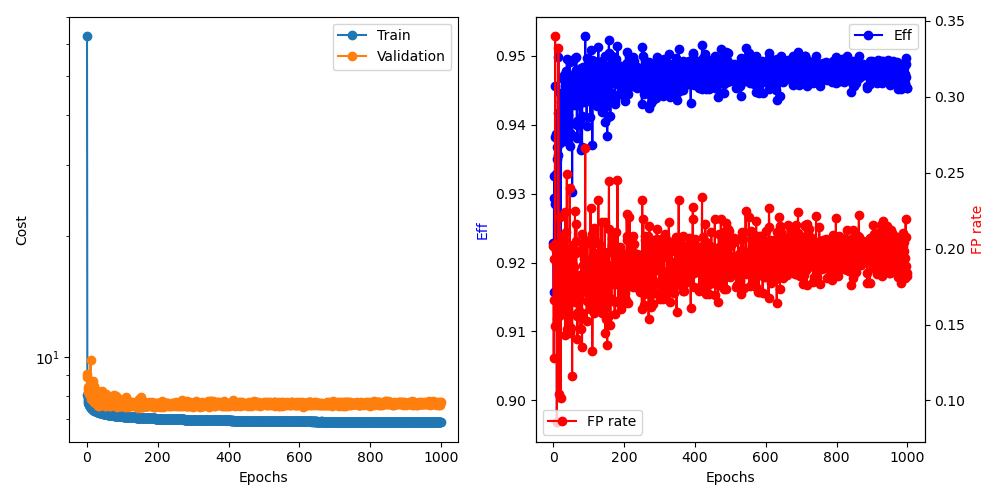

In [12]:
print('for model: ', model)   
run_name = 'UNet_D'
# Create an mlflow run
with mlflow.start_run(run_name=run_name) as run:
    # Log parameters of the model
    for key, value in vars(args).items():
        print(key, value)
        mlflow.log_param(key, value)
    
    # Log parameter count in the model
    mlflow.log_param('Parameters', count_parameters(model))
    
    # Begin run
    for result in trainNet(model, optimizer, loss,
                            train_loader, val_loader,
                            args.epochs+args.epoch_start, epoch_start=args.epoch_start,
                            notebook=True, device=device):

        result = result._asdict()
        results = results.append(pd.Series(result), ignore_index=True)
    
        xs = results.index
    
        # Update the plot above
        lines['train'].set_data(results.index,results.cost)
        lines['val'].set_data(results.index,results.val)
    
        #filter first cost epoch (can be really large)
        max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
        min_cost = min(min(results.cost), min(results.val))
    
        # The plot limits need updating too
        ax.set_ylim(min_cost*.9, max_cost*1.1)  
        ax.set_xlim(-.5, len(results.cost) - .5)
    
        replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
        replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
        # Redraw the figure
        fig.canvas.draw()
            
        ## MLFLOW ##
        # Log metrics
        mlflow.log_metric('Efficiency', result['eff_val'].eff_rate, result['epoch'])
        mlflow.log_metric('False Positive Rate',  result['eff_val'].fp_rate, result['epoch'])
        mlflow.log_metric('Validation Loss',  result['val'], result['epoch'])
        mlflow.log_metric('Training Loss',  result['cost'], result['epoch'])
            
        # Log tags
        mlflow.set_tag('Optimizer', 'Adam')
        mlflow.set_tag('Kernel size', 'Mixed')
        mlflow.set_tag('Skip connections', '3')
        mlflow.set_tag('Activation', 'Softplus')
        mlflow.set_tag('Mid Activation', 'Relu')
        mlflow.set_tag('Extra Data', 'False')

        # Save model state dictionary, optimizer state dictionary, and epoch number
        torch.save({
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'epoch':args.epochs+result['epoch']
            }, 'run_stats.pyt')
        # Save the run stats into mlflow
        mlflow.log_artifact('run_stats.pyt')
            
        # Save a diagram of the architecture
#        HL.transforms.Fold("Conv", "Conv"),
#        HL.build_graph(model, torch.zeros([args.batch_size, 1, 4000]).to(device)).save('architecture', format='png')
#        mlflow.log_artifact('architecture.png')
        
        # log the code for the model architecture
#        mlflow.log_artifact('architecture.txt')
        
    dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
    # save plot
    plt.tight_layout()
    plt.savefig('plot.png')
    mlflow.log_artifact('plot.png')

In [13]:
##quit()